In [12]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import statsmodels.api as sm
from arch import arch_model
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
matplotlib.rcParams['font.sans-serif'] =  ['Heiti TC']
matplotlib.rcParams['font.serif'] =  ['Heiti TC']
matplotlib.rcParams['axes.unicode_minus'] = False
import pystable
from scipy.stats import spearmanr 
from scipy.stats import levy_stable
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize
import operator
from mpl_toolkits.mplot3d import Axes3D

In [9]:
#读取数据
sw = pd.read_csv('sw.csv',index_col=0)
esg = pd.read_csv('esg_new.csv',index_col=0)
macro = pd.read_csv('macro.csv',index_col=0)

# 收缩与扩张时期

In [3]:
macro.head()

,stat_month,m2,m1,m0,m2_yoy,m1_yoy,m0_yoy,label
125,2005-02-01,259357.29,92814.95,22667.97,13.9,10.6,14.0,0
124,2005-03-01,264588.94,94743.19,21238.95,14.0,9.9,10.1,0
130,2005-04-01,266992.66,94593.72,21666.56,14.1,10.0,9.0,0
129,2005-05-01,269240.49,95802.01,20811.59,14.7,10.4,9.3,0
128,2005-06-01,275785.53,98601.25,20848.76,15.7,11.3,9.6,0


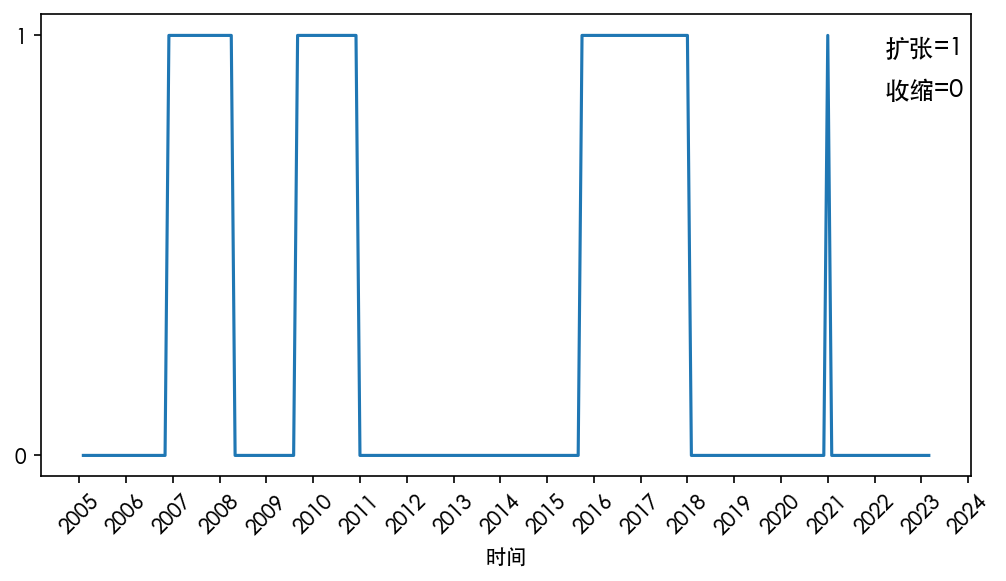

In [4]:
#1为扩张，0为收缩
plt.figure(figsize=(8,4),dpi=150)
# 设置日期格式
date_format = mdates.DateFormatter('%Y')  # 只显示年份
# 将日期格式应用于横坐标
plt.gca().xaxis.set_major_formatter(date_format)
# 设置日期刻度间隔，这里设置为一年
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(pd.to_datetime(macro.stat_month),macro.label)
plt.xlabel('时间')
plt.ylabel('')
plt.yticks(np.arange(2))
plt.xticks(rotation=45)
# 在右上角添加注释
plt.text(datetime(2023,12,1),1, '扩张=1', horizontalalignment='right', verticalalignment='top', fontsize=12)
plt.text(datetime(2023,12,1),0.9, '收缩=0', horizontalalignment='right', verticalalignment='top', fontsize=12)
plt.show()

# 周期性板块

In [5]:
change_points = macro[macro['label'].diff() != 0]
change_month = change_points['stat_month']

In [6]:
#获取beta
def get_beta(sr,hs):
    n = len(sr)
#     sr = sr-0.03
#     sum_x = sr.sum()
#     sum_y = hs.sum()
#     sum_x_y = (sr*hs).sum()
#     sum_x_square = (sr ** 2).sum()

#     # 计算回归系数（斜率）
#     beta = (n * sum_x_y - sum_x * sum_y) / (n * sum_x_square - sum_x ** 2)
    model = LinearRegression(fit_intercept=False)
    model.fit(hs.values.reshape(-1,1),sr.values.reshape(-1,1))
    beta = model.coef_[0][0]
    return beta

In [7]:
col_name = sw.columns[:-1]
beta = []
for i in col_name:
    beta.append(get_beta(sw[i],sw['沪深300']))
beta.append(1)
beta = np.array(beta)
cir = sw.loc[:,beta>1.03]
no_cir = sw.loc[:,beta<0.97]

In [8]:
df_cirulate = pd.DataFrame(index=['非周期性板块','周期性板块'])
for i in range(len(change_month)-3):
    s,e = change_month.iloc[i],change_month.iloc[i+1]
    #收缩期间->非周期性行业->beta小于0
    df_no_cir = no_cir[(no_cir.index>=s) & (no_cir.index<e)]
    df_cir = cir[(cir.index>=s) & (cir.index<e)]
    df_cirulate[e] = [df_no_cir.sum().sum()/len(df_no_cir.columns),df_cir.sum().sum()/len(df_cir.columns)]

In [9]:
df_no_cir = no_cir[no_cir.index>=e]
df_cir = cir[cir.index>=e]

In [10]:
df_cirulate['2023-03-01'] = [df_no_cir.sum().sum()/len(df_no_cir.columns),df_cir.sum().sum()/len(df_cir.columns)]

In [11]:
print(abs(df_cirulate.iloc[0,:]-df_cirulate.iloc[1,:]))

2006-12-01    0.088269
2008-05-01    0.228601
2009-09-01    0.095720
2011-01-01    0.109554
2015-10-01    0.595828
2018-02-01    0.232754
2023-03-01    0.054827
dtype: float64


# 时间序列

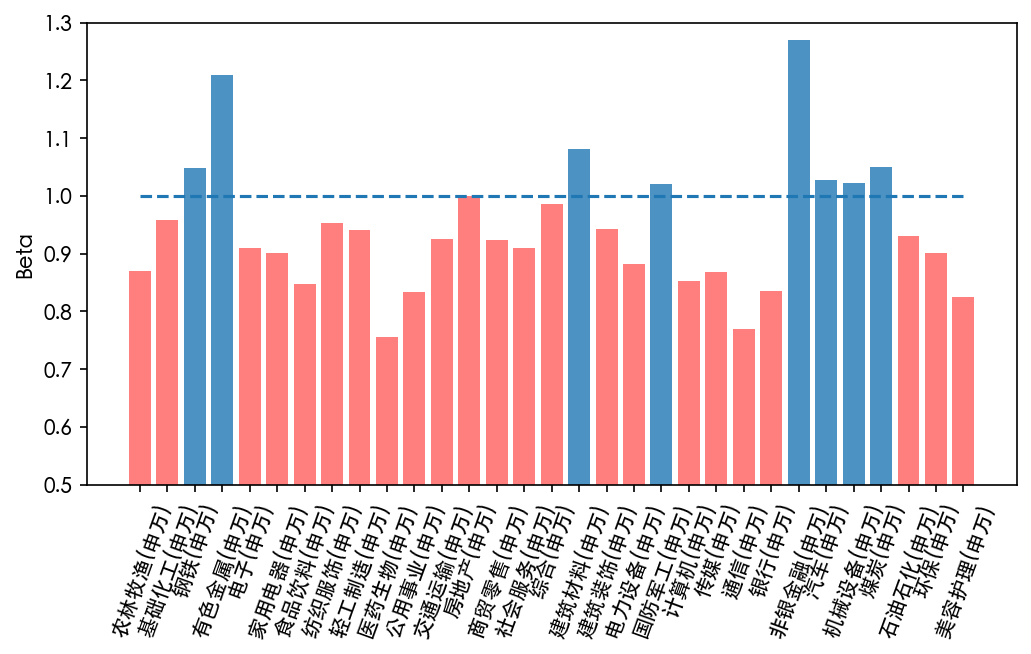

In [12]:
df_beta = pd.DataFrame(data=beta,index=sw.columns,columns=['beta'])
plt.figure(figsize=(8,4),dpi=150)
x = df_beta.iloc[:-1]
df_beta_0 = x[x.beta<1]
df_beta_1 = x[x.beta>1]
plt.plot(x.index,[1]*x.shape[0],linestyle='--')
plt.bar(df_beta_0.index,df_beta_0.beta,color='red',alpha=0.5)
plt.bar(df_beta_1.index,df_beta_1.beta,alpha=0.8)
plt.xticks(rotation=70)
plt.ylabel('Beta')
plt.ylim(0.5,1.3)
plt.show()

In [13]:
li_house = []
li_medicine = []
li_machine = []
for i in range(120,len(sw)):   
    li_house.append(get_beta(sw['房地产(申万)'][i-120:i],sw['沪深300'][i-120:i]))
    li_medicine.append(get_beta(sw['医药生物(申万)'][i-120:i],sw['沪深300'][i-120:i]))
    li_machine.append(get_beta(sw['国防军工(申万)'][i-120:i],sw['沪深300'][i-120:i]))

In [14]:
b = df_beta_0 = x[x.beta<0.97]

In [15]:
sw.index = pd.to_datetime(sw.index).strftime('%Y-%m')
df = sw.loc[:,b.index]

In [16]:
def get_forcast(name,n,df,window):
    ans = []
    sr = df[name]
    for i in range(n):
        x = i-n
        s_1 = sr.iloc[x-window:x]
        s_1.index = range(len(s_1))
        #构建arima-egarch
        model = auto_arima(s_1,trace=True,error_action='ignore',suppress_warnings=True)
        res = model.fit(s_1)
        am = arch_model(res.resid(),vol='EGARCH',p=1,q=1)
        egarch_res = am.fit()
        forecasts = egarch_res.forecast(start=s_1.index[-1],horizon=1)
        ans.append(forecasts.mean.iloc[-1].values[0])
    return(ans)

In [17]:
arima_return = pd.DataFrame()

In [18]:
for j in df.columns:
    arima_return[j] = get_forcast(j,8,df,108)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-231.529, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-234.656, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-233.451, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-233.452, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-236.215, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-231.460, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.127 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2028.8854954087826
Iteration:      2,   Func. Count:     17,   Neg. LLF: 226.557307685097
Iteration:      3,   Func. Count:     26,   Neg. LLF: -64.21882925173122
Iteration:      4,   Func. Count:     33,   Neg. LLF: -118.79939661028347
Iteration:      5,   Func. Count:     41,   Neg. LLF: -121.73752252926981
Iteration:      6,   Func. Count:     46,   Neg. LLF: -121.73083515623715
Iteration:      7,   Func. Count:     52,   N

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-235.810, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-234.621, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-234.630, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-237.157, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-232.635, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.118 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1751.357231028524
Iteration:      2,   Func. Count:     17,   Neg. LLF: 245.95001050762255
Iteration:      3,   Func. Count:     26,   Neg. LLF: -84.99468058487105
Iteration:      4,   Func. Count:     33,   Neg. LLF: -117.65176219761605
Iteration:      5,   Func. Count:     41,   Neg. LLF: -122.35392913596188
Iteration:      6,   Func. Count:     46,   Neg. LLF: -122.35407235326353
Iteration:      7,   Func. Count:     51,   Neg. LLF: -122.35407528011056
Iteration:      8,   Func. Count:     55,   Neg. LLF: -122.35407527925855
Optim

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-233.006, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-236.198, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-234.977, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-234.985, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-237.485, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-232.990, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.137 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6888.619051107939
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24.907293807334458
Iteration:      3,   Func. Count:     25,   Neg. LLF: 13205.66136581413
Iteration:      4,   Func. Count:     33,   Neg. LLF: -122.20194844974914
Iteration:      5,   Func. Count:     39,   Neg. LLF: -122.68581252565339
Iteration:      6,   Func. Count:     44,   Neg. LLF: -122.68692898072032
Iteration:      7,   Func. Count:     49,   Neg. LLF: -122.68724481763722
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00635. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-231.436, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-234.040, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-232.999, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-233.001, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-235.616, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-231.012, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.137 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 84486003079524.23
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5513.346300090644
Iteration:      3,   Func. Count:     25,   Neg. LLF: 57.48917615114491
Iteration:      4,   Func. Count:     32,   Neg. LLF: -120.39174240447244
Iteration:      5,   Func. Count:     39,   Neg. LLF: -121.7223580036038
Iteration:      6,   Func. Count:     44,   Neg. LLF: -121.72313785071148
Iteration:      7,   Func. Count:     49,   Neg. LLF: -121.72348875068646
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-246.841, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-248.326, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-245.731, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.902, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-248.822, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-246.546, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-249.107, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-249.157, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-247.362, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-247.312, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-245.369, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-249.890, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-250.161, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-248.190, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-249.489, Time=0.03 sec
 ARIMA(1,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     45,   Neg. LLF: -134.83725262601823
Iteration:      7,   Func. Count:     50,   Neg. LLF: -134.83726613450014
Iteration:      8,   Func. Count:     55,   Neg. LLF: -134.8372676831138
Iteration:      9,   Func. Count:     59,   Neg. LLF: -134.83726768160653
Optimization terminated successfully    (Exit mode 0)
            Current function value: -134.8372676831138
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-248.271, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-244.366, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-246.283, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-247.564, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-245.022, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.119, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-244.703, Time=0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 50011.47417977416
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4065.8606372277695
Iteration:      3,   Func. Count:     23,   Neg. LLF: 56029350672.335754
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.35996247257586
Iteration:      5,   Func. Count:     38,   Neg. LLF: -136.9537980322204
Iteration:      6,   Func. Count:     43,   Neg. LLF: -136.97269977677539
Iteration:      7,   Func. Count:     48,   Neg. LLF: -136.97303139798103
Iteration:      8,   Func. Count:     53,   Neg. LLF: -136.97304888016237
Iteration:      9,   Func. Count:     57,   Neg. LLF: -136.97304888043038
Optimization terminated successfully    (Exit mode 0)
            Current function value: -136.97304888016237
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-248.337, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 3408941.313747812
Iteration:      2,   Func. Count:     16,   Neg. LLF: 45845.99379978904
Iteration:      3,   Func. Count:     24,   Neg. LLF: 76717513.19940184
Iteration:      4,   Func. Count:     32,   Neg. LLF: -129.56536621775578
Iteration:      5,   Func. Count:     40,   Neg. LLF: -136.67164388496164
Iteration:      6,   Func. Count:     45,   Neg. LLF: -136.67349280640906
Iteration:      7,   Func. Count:     50,   Neg. LLF: -136.673578295028
Iteration:      8,   Func. Count:     55,   Neg. LLF: -136.67358495672613
Iteration:      9,   Func. Count:     59,   Neg. LLF: -136.67358495672784
Optimization terminated successfully    (Exit mode 0)
            Current function value: -136.67358495672613
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-247.374, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] 

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-244.559, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-246.664, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-243.213, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-246.322, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-244.275, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-244.468, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-245.280, Time=0.04 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-243.073, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-247.471, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-245.347, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-247.288, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-243.909, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-245.584, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-245.229, Time=0.03 sec
 ARIMA(3,0,1)(0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005319. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-246.385, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-241.727, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-244.275, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-245.704, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-242.884, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-243.957, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-246.088, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-242.611, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-245.950, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-243.850, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-243.544, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-244.754, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-242.628, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-247.176, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-244.952, Time=0.03 sec
 ARIMA(2,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-246.652, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-241.774, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-244.130, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-245.559, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-242.945, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-243.997, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-246.199, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-242.784, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-245.206, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-243.721, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-243.670, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-244.926, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-242.880, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-247.513, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-244.968, Time=0.02 sec
 ARIMA(2,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005332. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-247.825, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-242.376, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-244.632, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-246.191, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-243.623, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-245.206, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-247.423, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-243.884, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-246.261, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-244.421, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-244.775, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-246.050, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-244.107, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-248.899, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-246.266, Time=0.02 sec
 ARIMA(2,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-205.826, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-206.444, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-206.801, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-209.269, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-207.412, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-207.913, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-208.414, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-207.988, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.295 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19340.56971222757
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7743.737096681699
Iteration:      3,   Func. Count:     24,   Neg. LLF: 18511023104.445427
Iteration:      4,   Func. Count:     32,   Neg. LLF: -109.46871575982833
Iteration:      5,   Func. Count:     38,   Neg. LLF: -111.59049669770462
Iteration:      6,   Func. Cou

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-205.363, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-206.010, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-206.763, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-206.758, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-206.024, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-208.333, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-209.395, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-209.437, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-204.934, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-205.755, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-208.433, Time=0.04 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-212.655, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-207.075, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-209.313, Time=0.03 sec
 ARIMA(3,0,2)(0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007385. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-205.778, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-206.436, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-207.116, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-207.000, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-205.243, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-205.742, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-206.099, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-208.532, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-206.633, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-206.995, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-207.855, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-207.035, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.212 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 73336.8179807784

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-204.915, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-205.387, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-206.004, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-206.298, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-204.112, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1574396904.8996735
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2746620.0802213247
Iteration:      3,   Func. Count:     23,   Neg. LLF: 207830966.44896826
Iteration:      4,   Func. Count:     31,   Neg. LLF: -102.98794786954745
Iteration:      5,   Func. Count:     38,   Neg. LLF: -110.03150920547986
Iteration:      6,   Func. Count:     43,   Neg. LLF: -110.04914097784281
Iteration:      7,   Func. Count:     48,   Neg. LLF: -110.04750615581955
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-205.489, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-206.091, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-206.625, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-205.367, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-207.722, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-209.365, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-209.415, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-204.206, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-205.611, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-208.448, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-207.227, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-212.402, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-206.627, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-208.939, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-210.703, Time=0.06 sec
 ARIMA(2,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-253.977, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-258.361, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-256.380, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-256.368, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-257.860, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-255.362, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.255 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 15690.249841110486
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13079560682.248716
Iteration:      3,   Func. Count:     22,   Neg. LLF: 465237.59660682274
Iteration:      4,   Func. Count:     30,   Neg. LLF: -133.41591211642844
Iteration:      5,   Func. Count:     38,   Neg. LLF: -136.503988995102
Iteration:      6,   Func. Count:     43,   Neg. LLF: -136.5067020545441
Iteration:      7,   Func. Count:     48,   Neg. LLF: -136.50672487468148
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005124. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-256.812, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-255.665, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-254.143, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-256.831, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-258.677, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-256.777, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-254.860, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-259.520, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-256.962, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-257.765, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-257.701, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-258.084, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-255.777, Time=0.10 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 0.941 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13937.83654

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-256.910, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-255.780, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-254.249, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-256.852, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-258.766, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-256.821, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-254.879, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-259.462, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-257.045, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-257.617, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-257.574, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-258.080, Time=0.02 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-255.630, Time=0.06 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 0.866 seconds


/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004853. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 36943.20670700677
Iteration:      2,   Func. Count:     16,   Neg. LLF: 33.73356665471445
Iteration:      3,   Func. Count:     25,   Neg. LLF: 151981052.42272812
Iteration:      4,   Func. Count:     33,   Neg. LLF: -136.32895110442075
Iteration:      5,   Func. Count:     39,   Neg. LLF: -136.64424049630207
Iteration:      6,   Func. Count:     44,   Neg. LLF: -136.64760686271939
Iteration:      7,   Func. Count:     49,   Neg. LLF: -136.6479641061388
Iteration:      8,   Func. Count:     54,   Neg. LLF: -136.64796766470724
Iteration:      9,   Func. Count:     58,   Neg. LLF: -136.6479676649935
Optimization terminated successfully    (Exit mode 0)
            Current function value: -136.64796766470724
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-256.432, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004849. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 98879.9489903794
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1438.4993586170347
Iteration:      3,   Func. Count:     24,   Neg. LLF: 329919358.36317766
Iteration:      4,   Func. Count:     32,   Neg. LLF: -135.2391660502838
Iteration:      5,   Func. Count:     40,   Neg. LLF: -136.5275502011968
Iteration:      6,   Func. Count:     45,   Neg. LLF: -136.52837408148417
Iteration:      7,   Func. Count:     50,   Neg. LLF: -136.5283958148469
Iteration:      8,   Func. Count:     55,   Neg. LLF: -136.5283971302595
Iteration:      9,   Func. Count:     59,   Neg. LLF: -136.5283971302699
Optimization terminated successfully    (Exit mode 0)
            Current function value: -136.5283971302595
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-256.364, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] int

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-252.957, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-255.049, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-252.029, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-252.723, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-253.484, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-252.909, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-255.414, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-257.363, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-254.367, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-255.404, Time=0.07 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-253.418, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-258.216, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-255.733, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-256.313, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-256.301, Time=0.03 sec
 ARIMA(1,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004917. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4458429.609363538
Iteration:      2,   Func. Count:     16,   Neg. LLF: 740402.5454503818
Iteration:      3,   Func. Count:     25,   Neg. LLF: -132.64115698051538
Iteration:      4,   Func. Count:     32,   Neg. LLF: -135.23970154089582
Iteration:      5,   Func. Count:     37,   Neg. LLF: -105.86601401027407
Iteration:      6,   Func. Count:     44,   Neg. LLF: -135.24291448266882
Iteration:      7,   Func. Count:     49,   Neg. LLF: -135.24294228545634
Iteration:      8,   Func. Count:     53,   Neg. LLF: -135.2429422860765
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.24294228545634
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-253.554, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-250.484, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] inter

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005003. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2285772860.621162
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4049989.8361897664
Iteration:      3,   Func. Count:     24,   Neg. LLF: 120.517663061398
Iteration:      4,   Func. Count:     31,   Neg. LLF: -135.14153645284847
Iteration:      5,   Func. Count:     36,   Neg. LLF: -132.83238825766
Iteration:      6,   Func. Count:     43,   Neg. LLF: -135.14768662578044
Iteration:      7,   Func. Count:     48,   Neg. LLF: -135.14773697151804
Iteration:      8,   Func. Count:     53,   Neg. LLF: -135.14774019764613
Iteration:      9,   Func. Count:     57,   Neg. LLF: -135.14774019763783
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.14774019764613
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-254.558, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] i

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

Iteration:      1,   Func. Count:      6,   Neg. LLF: 44535869644.3699
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7795646.235386091
Iteration:      3,   Func. Count:     24,   Neg. LLF: 151.2832339780224
Iteration:      4,   Func. Count:     31,   Neg. LLF: -134.3101729361328
Iteration:      5,   Func. Count:     37,   Neg. LLF: -135.829552735866
Iteration:      6,   Func. Count:     43,   Neg. LLF: -135.87690470180232
Iteration:      7,   Func. Count:     48,   Neg. LLF: -135.877005697285
Iteration:      8,   Func. Count:     53,   Neg. LLF: -135.8770088872335
Iteration:      9,   Func. Count:     57,   Neg. LLF: -135.87700888697927
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.8770088872335
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept  

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-225.824, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-224.004, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-224.023, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-224.151, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-222.039, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.120 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1067.854064540036
Iteration:      2,   Func. Count:     16,   Neg. LLF: 239.63971691745098
Iteration:      3,   Func. Count:     24,   Neg. LLF: -28.324953628087254
Iteration:      4,   Func. Count:     31,   Neg. LLF: -109.86706345122334
Iteration:      5,   Func. Count:     38,   Neg. LLF: -116.42495838216882
Iteration:      6,   Func. Count:     43,   Neg. LLF: -116.42619321303548
Iteration:      7,   Func. Count:     48,   Neg. LLF: -116.42626787593005
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006972. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-223.980, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-222.275, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-222.297, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-222.866, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-220.305, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.110 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1022.5167985355496
Iteration:      2,   Func. Count:     16,   Neg. LLF: 266.40295575155466
Iteration:      3,   Func. Count:     24,   Neg. LLF: -107.54890706669879
Iteration:      4,   Func. Count:     31,   Neg. LLF: -114.9679676756802
Iteration:      5,   Func. Count:     37,   Neg. LLF: -112.71879630189923
Iteration:      6,   Func. Count:     43,   Neg. LLF: -115.05709446099152
Iteration:      7,   Func. Count:     48,   Neg. LLF: -115.05867275112296
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-220.190, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-224.146, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-222.467, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-222.499, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-223.032, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-220.514, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.112 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1099.6543459614222
Iteration:      2,   Func. Count:     15,   Neg. LLF: 242.10123190416198
Iteration:      3,   Func. Count:     23,   Neg. LLF: 20.031493176849235
Iteration:      4,   Func. Count:     29,   Neg. LLF: -112.50450956906724
Iteration:      5,   Func. Count:     35,   Neg. LLF: -112.4271154073103
Iteration:      6,   Func. Count:     41,   Neg. LLF: -113.90003587252184
Iteration:      7,   Func. Count:     47,   Neg. LLF: -114.9404078463762
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.946, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-252.430, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-250.436, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-250.449, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-252.028, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-248.941, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.199 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 980982969857.1414
Iteration:      2,   Func. Count:     16,   Neg. LLF: 808714086.9108962
Iteration:      3,   Func. Count:     24,   Neg. LLF: 570624937.3795449
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.71048877441663
Iteration:      5,   Func. Count:     38,   Neg. LLF: -116.96459555902995
Iteration:      6,   Func. Count:     44,   Neg. LLF: -139.07977717342857
Iteration:      7,   Func. Count:     49,   Neg. LLF: -139.0807175570109
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005447. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.514, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-252.063, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-250.080, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-250.115, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-251.730, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-248.514, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.212 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 986127030303.3544
Iteration:      2,   Func. Count:     16,   Neg. LLF: 916422112.9830055
Iteration:      3,   Func. Count:     24,   Neg. LLF: 567752249.3690333
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.40313280485432
Iteration:      5,   Func. Count:     38,   Neg. LLF: -124.50355858713166
Iteration:      6,   Func. Count:     44,   Neg. LLF: -138.6395938610429
Iteration:      7,   Func. Count:     49,   Neg. LLF: -138.64488396983947
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.410, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-251.985, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-250.005, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-250.043, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-251.657, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-248.410, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.204 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 831833631734.3472
Iteration:      2,   Func. Count:     16,   Neg. LLF: 993989055.2958416
Iteration:      3,   Func. Count:     24,   Neg. LLF: 624646683.8246337
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.43675324552873
Iteration:      5,   Func. Count:     38,   Neg. LLF: -129.26915709131882
Iteration:      6,   Func. Count:     44,   Neg. LLF: -138.56066109472033
Iteration:      7,   Func. Count:     49,   Neg. LLF: -138.5672838580465
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-247.296, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-245.779, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-251.269, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-249.278, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-249.294, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-250.906, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-247.777, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.242 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 966535140041.1826
Iteration:      2,   Func. Count:     16,   Neg. LLF: 796944884.1128657
Iteration:      3,   Func. Count:     24,   Neg. LLF: 289060850.40594846
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.31511808081171
Iteration:      5,   Func. Count:     38,   Neg. LLF: -125.64201813788792
Iteration:      6,   Func. Count:     44,   Neg. LLF: -138.27161411291488
Iteration:      7,   F

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-247.444, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-247.459, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-245.895, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-251.436, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-249.444, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-249.459, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-251.082, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-247.895, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.192 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1558568736744.135
Iteration:      2,   Func. Count:     16,   Neg. LLF: 17440594.428419556
Iteration:      3,   Func. Count:     24,   Neg. LLF: 666329.3635042139
Iteration:      4,   Func. Count:     31,   Neg. LLF: 35964052.03404452
Iteration:      5,   Func. Count:     38,   Neg. LLF: -138.56242806389562
Iteration:      6,   Func. Count

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005505. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for re

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-247.319, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-247.345, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-245.731, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-251.306, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-249.319, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-249.345, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-250.989, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-247.730, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.190 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1552908496155.4932
Iteration:      2,   Func. Count:     16,   Neg. LLF: 20454698.365699004
Iteration:      3,   Func. Count:     24,   Neg. LLF: 139987.74321591618
Iteration:      4,   Func. Count:     31,   Neg. LLF: 30049464.865379315
Iteration:      5,   Func. Count:     38,   Neg. LLF: -138.97107319578654
Iteration:      6,   Func. Co

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005517. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-247.339, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-249.285, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-249.720, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-249.337, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-246.506, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-247.971, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-248.210, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-248.294, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-247.720, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-246.297, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-247.502, Time=0.04 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-246.013, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-251.983, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-248.498, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-249.959, Time=0.02 sec
 ARIMA(3,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-235.665, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-239.503, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-237.833, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-238.270, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-238.037, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.477, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.246 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5733208.783680697
Iteration:      2,   Func. Count:     16,   Neg. LLF: 114560.68650214122
Iteration:      3,   Func. Count:     24,   Neg. LLF: 452992897.94374096
Iteration:      4,   Func. Count:     32,   Neg. LLF: -126.53924043091838
Iteration:      5,   Func. Count:     38,   Neg. LLF: -111.52410920490824
Iteration:      6,   Func. Count:     44,   Neg. LLF: -128.99149689517128
Iteration:      7,   Func. Count:     49,   Neg. LLF: -129.01634303911212
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-235.622, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-239.644, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-237.902, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-238.229, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-238.366, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.430, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.236 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 13585322.324922986
Iteration:      2,   Func. Count:     16,   Neg. LLF: 62930.84025993113
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1055313340.2396138
Iteration:      4,   Func. Count:     32,   Neg. LLF: -126.60403975351673
Iteration:      5,   Func. Count:     38,   Neg. LLF: 58445215.93323488
Iteration:      6,   Func. Count:     45,   Neg. LLF: -129.02898510596248
Iteration:      7,   Func. Count:     50,   Neg. LLF: -129.0375188844401
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006124. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-235.324, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-239.366, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-237.632, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-237.939, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-238.013, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.108, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.215 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 67806440.14581446
Iteration:      2,   Func. Count:     16,   Neg. LLF: 152088.45441754046
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1064145666.0516518
Iteration:      4,   Func. Count:     32,   Neg. LLF: -126.2512982895981
Iteration:      5,   Func. Count:     38,   Neg. LLF: -121.570545777143
Iteration:      6,   Func. Count:     45,   Neg. LLF: -128.6122259344392
Iteration:      7,   Func. Count:     50,   Neg. LLF: -128.61428243666438
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.465, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-238.353, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-236.715, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-237.130, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-237.029, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-236.293, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.222 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 194697505.82703426
Iteration:      2,   Func. Count:     16,   Neg. LLF: 456029.997337769
Iteration:      3,   Func. Count:     24,   Neg. LLF: 579148837.5710194
Iteration:      4,   Func. Count:     32,   Neg. LLF: -125.78572633118446
Iteration:      5,   Func. Count:     38,   Neg. LLF: -126.411216752953
Iteration:      6,   Func. Count:     44,   Neg. LLF: -128.0423372043103
Iteration:      7,   Func. Count:     49,   Neg. LLF: -128.04630438256635
Iteration:      8,

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.358, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-238.256, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-236.610, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-237.018, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.863, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-236.205, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.214 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4373756538.0791645
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8188678.563798341
Iteration:      3,   Func. Count:     24,   Neg. LLF: 254752409.3651749
Iteration:      4,   Func. Count:     32,   Neg. LLF: -125.59501996525206
Iteration:      5,   Func. Count:     38,   Neg. LLF: -127.36573076828043
Iteration:      6,   Func. Count:     44,   Neg. LLF: -127.8162719672864
Iteration:      7,   Func. Count:     49,   Neg. LLF: -127.82681805311795
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006205. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.140, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-238.120, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-236.439, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-236.803, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.752, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-236.033, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.239 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 316119773928.82556
Iteration:      2,   Func. Count:     16,   Neg. LLF: 30419025.08530137
Iteration:      3,   Func. Count:     24,   Neg. LLF: 29226685.220889535
Iteration:      4,   Func. Count:     32,   Neg. LLF: -125.59901530300557
Iteration:      5,   Func. Count:     38,   Neg. LLF: -127.57805611072395
Iteration:      6,   Func. Count:     44,   Neg. LLF: -127.79892349295383
Iteration:      7,   Func. Count:     50,   Neg. LLF: -127.82777565093708
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.186, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-237.988, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-236.305, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-236.707, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.640, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-236.080, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.228 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 537599547687.4541
Iteration:      2,   Func. Count:     16,   Neg. LLF: 17681083.689382106
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6613002.160495538
Iteration:      4,   Func. Count:     32,   Neg. LLF: -125.74322968450035
Iteration:      5,   Func. Count:     38,   Neg. LLF: -127.87326737402253
Iteration:      6,   Func. Count:     44,   Neg. LLF: -127.9506903551515
Iteration:      7,   Func. Count:     50,   Neg. LLF: -127.99193015819806
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006223. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.603, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-238.002, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-236.398, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-236.928, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.541, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-236.516, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.289 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 503378643292.4666
Iteration:      2,   Func. Count:     16,   Neg. LLF: 15577172.667889517
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1573040.871931862
Iteration:      4,   Func. Count:     32,   Neg. LLF: -125.94958001934855
Iteration:      5,   Func. Count:     38,   Neg. LLF: -128.10017734126916
Iteration:      6,   Func. Count:     44,   Neg. LLF: -128.12799903044166
Iteration:      7,   Func. Count:     50,   Neg. LLF: -128.23348330259736
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006222. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-241.615, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.110 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1464150.345173687
Iteration:      2,   Func. Count:     15,   Neg. LLF: 171478244.02972162
Iteration:      3,   Func. Count:     23,   Neg. LLF: 17055218400.646603
Iteration:      4,   Func. Count:     31,   Neg. LLF: -123.45808641136242
Iteration:      5,   Func. Count:     39,   Neg. LLF: -128.6639306572092
Iteration:      6,   Func. Count:     44,   Neg. LLF: -128.66476486402496
Iteration:      7,   Func. Count:     49,   Neg. LLF: -128.6648526955068
Iteration:      8,   Func. Count:     54,   Neg. LLF: -128.66488706104738
Iteration:      9,   Func. Count:     59,   Neg. LLF: -128.6648899694189
Iteration:     10,   Func. Count:     63,   Neg. LLF: -128.66488996998137
Optimization terminated successfully    (Exit mode 0)
            Current function value: -128.6648899694189
            Ite

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005959. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-243.070, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-244.221, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-241.169, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.123 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 364319.77496851893
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1720069.7613298497
Iteration:      3,   Func. Count:     23,   Neg. LLF: 237718982.88055772
Iteration:      4,   Func. Count:     31,   Neg. LLF: -122.95292732902577
Iteration:      5,   Func. Count:     39,   Neg. LLF: -127.94403198532625
Iteration:      6,   Func. Count:     44,   Neg. LLF: -127.94721760449863
Iteration:      7,   Func. Count:     49,   Neg. LLF: -127.94966910577553
Iteration:      8,   Func. Count:     54,   Neg. LLF: -127.94972347614558
Iteration:      9,   Func. Count:     59,   Neg. LLF: -127.94973229028517
Iteration:     10,   Func. Count:     63,   Neg. LLF: -127.949

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-243.396, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-244.503, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-241.509, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.098 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19195037.09905213
Iteration:      2,   Func. Count:     15,   Neg. LLF: 751685.5010757848
Iteration:      3,   Func. Count:     23,   Neg. LLF: 105666406.02262737
Iteration:      4,   Func. Count:     31,   Neg. LLF: -123.45211773764308
Iteration:      5,   Func. Count:     39,   Neg. LLF: -128.1583698086923
Iteration:      6,   Func. Count:     44,   Neg. LLF: -128.1640357790435
Iteration:      7,   Func. Count:     49,   Neg. LLF: -128.16534701735955
Iteration:      8,   Func. Count:     54,   Neg. LLF: -128.16552362062924
Iteration:      9,   Func. Count:     59,   Neg. LLF: -128.16552607718697
Iteration:     10,   Func. Count:     63,   Neg. LLF: -128.1655260

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-241.463, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-242.672, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-242.588, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-242.934, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-244.227, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-241.041, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.128 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 27488945000.291416
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1462619.3821260848
Iteration:      3,   Func. Count:     23,   Neg. LLF: 31210031.716216147
Iteration:      4,   Func. Count:     30,   Neg. LLF: -123.47751188111094
Iteration:      5,   Func. Count:     37,   Neg. LLF: -128.14941783143988
Iteration:      6,   Func. Count:     42,   Neg. LLF: -128.16917807531598
Iteration:      7,   Func. Count:     47,   Neg. LLF: -128.1751051255658
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-255.889, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-261.659, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.353, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-260.448, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-263.598, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-258.666, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.118 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 170976060.83973116
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3161976.0951147536
Iteration:      3,   Func. Count:     24,   Neg. LLF: 403196378.01670176
Iteration:      4,   Func. Count:     32,   Neg. LLF: -137.59577572364458
Iteration:      5,   Func. Count:     38,   Neg. LLF: -129.55110619053642
Iteration:      6,   Func. Count:     44,   Neg. LLF: -140.38941686716524
Iteration:      7,   Func. Count:     49,   Neg. LLF: -140.39658096964186
Iteration:  

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00499. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-255.155, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-262.141, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.833, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-260.929, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-264.024, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-259.155, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.192 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 768644823905.2666
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1726328.1880473834
Iteration:      3,   Func. Count:     24,   Neg. LLF: 129246841.73997825
Iteration:      4,   Func. Count:     32,   Neg. LLF: -137.76453162446285
Iteration:      5,   Func. Count:     38,   Neg. LLF: -139.56493063200722
Iteration:      6,   Func. Count:     44,   Neg. LLF: -140.5836536545223
Iteration:      7,   Func. Count:     49,   Neg. LLF: -140.60050728664353
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-259.103, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.156 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 812327644100.5625
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3722427.4595244043
Iteration:      3,   Func. Count:     24,   Neg. LLF: 82739166.4944508
Iteration:      4,   Func. Count:     32,   Neg. LLF: -138.00011489250352
Iteration:      5,   Func. Count:     38,   Neg. LLF: -139.8962642135504
Iteration:      6,   Func. Count:     44,   Neg. LLF: -140.81257248325744
Iteration:      7,   Func. Count:     50,   Neg. LLF: -140.85856854665812
Iteration:      8,   Func. Count:     55,   Neg. LLF: -140.8585019163986
Iteration:      9,   Func. Count:     61,   Neg. LLF: -140.85753358480375
Iteration:     10,   Func. Count:     67,   Neg. LLF: -140.8574767063696
Iteration:     11,   Func. Count:     73,   Neg. LLF: -140.85745671460742
Iteration:     12,   Func. Count:     79,   Neg. LLF

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004997. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-255.694, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-261.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.456, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-260.551, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-263.654, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-258.797, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.144 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 756308142183.431
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2853425.296498176
Iteration:      3,   Func. Count:     24,   Neg. LLF: 32352262.22243286
Iteration:      4,   Func. Count:     32,   Neg. LLF: -138.66281450209397
Iteration:      5,   Func. Count:     38,   Neg. LLF: -140.7851833747398
Iteration:      6,   Func. Count:     44,   Neg. LLF: -141.5556761881351
Iteration:      7,   Func. Count:     50,   Neg. LLF: -141.62551749150404
Iteration:      8,

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004978. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-275.126, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.201 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 730724771725.4161
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16707927.035096439
Iteration:      3,   Func. Count:     25,   Neg. LLF: -62.88878488713241
Iteration:      4,   Func. Count:     32,   Neg. LLF: 8953.812500931983
Iteration:      5,   Func. Count:     39,   Neg. LLF: -144.137458437345
Iteration:      6,   Func. Count:     44,   Neg. LLF: -144.18902314629844
Iteration:      7,   Func. Count:     49,   Neg. LLF: -144.19301882112623
Iteration:      8,   Func. Count:     54,   Neg. LLF: -144.19653200975353
Iteration:      9,   Func. Count:     59,   Neg. LLF: -144.19678571990923
Iteration:     10,   Func. Count:     64,   Neg. LLF: -144.1969299073157
Iteration:     11,   Func. Count:     69,   Neg. LLF: -144.196978

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-273.733, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-273.113, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-271.861, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-271.857, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-269.854, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-275.569, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-273.582, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-273.579, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-275.434, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-271.576, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 857180629200.8368
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4392728.268143031
Iteration:      3,   Func. Count:     25,   Neg. LLF: -87.82374182977942
Iteration:      4,   Func. Count:     31,   Ne

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004386. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-271.504, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-273.824, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-273.709, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-273.135, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-271.842, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-271.838, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-269.834, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-275.580, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-273.591, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-273.589, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-275.441, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-271.586, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.307 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 855059514470.3203
Iteration:      2,   Func. Count:     16,   Neg. LLF: 34380

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     23,   Func. Count:    148,   Neg. LLF: -153.10814000362737
Iteration:     24,   Func. Count:    154,   Neg. LLF: 28497539.129052345
Iteration:     25,   Func. Count:    161,   Neg. LLF: 28712192.630121198
Iteration:     26,   Func. Count:    169,   Neg. LLF: -150.07395352637988
Iteration:     27,   Func. Count:    175,   Neg. LLF: -123.92941793182295
Iteration:     28,   Func. Count:    181,   Neg. LLF: -35.26991043824517
Iteration:     29,   Func. Count:    188,   Neg. LLF: 36661414.54508774
Iteration:     30,   Func. Count:    197,   Neg. LLF: -156.29783746263558
Iteration:     31,   Func. Count:    202,   Neg. LLF: -76.50821152641352
Iteration:     32,   Func. Count:    210,   Neg. LLF: 228310247.5837044
Iteration:     33,   Func. Count:    225,   Neg. LLF: -148.6504169685453
Iteration:     34,   Func. Count:    240,   Neg. LLF: -83.62617554846841
Iteration:     35,   Func. Count:    255,   Neg. LLF: 51037080.2627853
Iteration:     36,   Func. Count:    270,   Neg. LL

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-267.875, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-271.501, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-273.804, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-273.698, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-273.114, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-271.823, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-271.819, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-269.816, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-275.545, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-273.558, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-273.556, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-275.414, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-271.553, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.339 seconds


/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comme

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1034578892820.8147
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1023068.3923911649
Iteration:      3,   Func. Count:     25,   Neg. LLF: 112339243.50774904
Iteration:      4,   Func. Count:     32,   Neg. LLF: -95.70878275372037
Iteration:      5,   Func. Count:     38,   Neg. LLF: 186.81781184427786
Iteration:      6,   Func. Count:     44,   Neg. LLF: -150.6055260880561
Iteration:      7,   Func. Count:     49,   Neg. LLF: 483.582131776389
Iteration:      8,   Func. Count:     56,   Neg. LLF: 4438567092.815282
Iteration:      9,   Func. Count:     64,   Neg. LLF: 4446197944.291777
Iteration:     10,   Func. Count:     72,   Neg. LLF: 8663610549.303917
Iteration:     11,   Func. Count:     81,   Neg. LLF: 8688364967.16693
Iteration:     12,   Func. Count:     90,   Neg. LLF: 8698384385.514095
Iteration:     13,   Func. Count:     99,   Neg. LLF: 10531015329.533232
Iteration:     14,   Func. Count:    108,   Neg. LLF: 1.621

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-270.628, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-270.627, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-268.625, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-274.442, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-272.448, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-272.447, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-274.287, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-270.448, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1241145654121.324
Iteration:      2,   Func. Count:     16,   Neg. LLF: 20612735.796466485
Iteration:      3,   Func. Count:     25,   Neg. LLF: 226329024.20308638
Iteration:      4,   Func. Count:     33,   Neg. LLF: 29183781.058050252
Iteration:      5,   Func. Count:     39,   Neg. LLF: 84912157.00681499
Iteration:      6,   Func. Count

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comme

Iteration:     44,   Func. Count:    367,   Neg. LLF: 2118631974.9497283
Iteration:     45,   Func. Count:    382,   Neg. LLF: 2118546979.3891616
Iteration:     46,   Func. Count:    397,   Neg. LLF: 2118525324.1472156
Iteration:     47,   Func. Count:    412,   Neg. LLF: 2118505033.4557142
Iteration:     48,   Func. Count:    427,   Neg. LLF: 2118647974.2628162
Iteration:     49,   Func. Count:    442,   Neg. LLF: 1997963876.6412146
Iteration:     50,   Func. Count:    457,   Neg. LLF: 4.026038584966826e+20
Iteration:     51,   Func. Count:    472,   Neg. LLF: 295149074263.9466
Iteration:     52,   Func. Count:    479,   Neg. LLF: 1083762368220.1514
Iteration:     53,   Func. Count:    487,   Neg. LLF: 835065873771.1278
Iteration:     54,   Func. Count:    502,   Neg. LLF: 4.499719148081677e+23
Iteration:     55,   Func. Count:    517,   Neg. LLF: 2722543559852.4487
Iteration:     56,   Func. Count:    523,   Neg. LLF: 244.1373812279225
Iteration:     57,   Func. Count:    531,   Neg.

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-249.577, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-248.794, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-249.435, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-249.351, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-250.787, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-247.450, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.205 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1913642653.6742864
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12458264.32464964
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1135025718.1332912
Iteration:      4,   Func. Count:     32,   Neg. LLF: -131.50993227889546
Iteration:      5,   Func. Count:     38,   Neg. LLF: -111.4204063544864
Iteration:      6,   Func. Count:     45,   Neg. LLF: -134.32438424879595
Iteration:      7,   Func. Count:     50,   Neg. LLF: -134.3281204845647
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-249.181, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-248.777, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-249.393, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-249.325, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-250.766, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-247.412, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.183 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 52253632457.88736
Iteration:      2,   Func. Count:     16,   Neg. LLF: 126594288.89573124
Iteration:      3,   Func. Count:     24,   Neg. LLF: 589690866.163234
Iteration:      4,   Func. Count:     32,   Neg. LLF: -131.45027806804444
Iteration:      5,   Func. Count:     38,   Neg. LLF: -120.96921383951995
Iteration:      6,   Func. Count:     45,   Neg. LLF: -134.05932896323753
Iteration:      7,   Func. Count:     50,   Neg. LLF: -134.05289093595795
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 971675725215.1674
Iteration:      2,   Func. Count:     16,   Neg. LLF: 100538646.08789766
Iteration:      3,   Func. Count:     24,   Neg. LLF: 408949083.5423247
Iteration:      4,   Func. Count:     32,   Neg. LLF: -131.55617822341546
Iteration:      5,   Func. Count:     38,   Neg. LLF: -127.19570215923204
Iteration:      6,   Func. Count:     44,   Neg. LLF: -133.99045691309135
Iteration:      7,   Func. Count:     49,   Neg. LLF: -133.99260260064196
Iteration:      8,   Func. Count:     54,   Neg. LLF: -133.99292894913634
Iteration:      9,   Func. Count:     59,   Neg. LLF: -133.99293136539814
Iteration:     10,   Func. Count:     63,   Neg. LLF: -133.99293136671983
Optimization terminated successfully    (Exit mode 0)
            Current function value: -133.99293136539814
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
Performing stepwise search to minimize aic
 ARIMA(2,0,

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1073892960710.8428
Iteration:      2,   Func. Count:     16,   Neg. LLF: 109608752.82098752
Iteration:      3,   Func. Count:     24,   Neg. LLF: 337366355.4678683
Iteration:      4,   Func. Count:     32,   Neg. LLF: -132.03752370125358
Iteration:      5,   Func. Count:     38,   Neg. LLF: -129.67456958568886
Iteration:      6,   Func. Count:     44,   Neg. LLF: -134.36756379017285
Iteration:      7,   Func. Count:     49,   Neg. LLF: -134.37073657850152
Iteration:      8,   Func. Count:     54,   Neg. LLF: -134.37122177797463
Iteration:      9,   Func. Count:     59,   Neg. LLF: -134.371233384691
Iteration:     10,   Func. Count:     63,   Neg. LLF: -134.3712333852067
Optimization terminated successfully    (Exit mode 0)
            Current function value: -134.371233384691
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-245.504, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-245.780, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-247.013, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-246.883, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-247.674, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-245.028, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1039407338445.9886
Iteration:      2,   Func. Count:     16,   Neg. LLF: 15394179.79565221
Iteration:      3,   Func. Count:     24,   Neg. LLF: 941313.7306200602
Iteration:      4,   Func. Count:     32,   Neg. LLF: -130.68597013074972
Iteration:      5,   Func. Count:     38,   Neg. LLF: -133.07602268004555
Iteration:      6,   Func. Count:     44,   Neg. LLF: -133.13109438573616
Iteration:      7,   Func. Count:     50,   Neg. LLF: -133.1468782564068
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-192.059, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-198.318, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-196.578, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-196.570, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-198.571, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-194.579, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.142 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2885.184544468711
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1012.3510847992056
Iteration:      3,   Func. Count:     25,   Neg. LLF: 14965370745.222244
Iteration:      4,   Func. Count:     33,   Neg. LLF: -103.68477355274041
Iteration:      5,   Func. Count:     40,   Neg. LLF: -107.62181850894152
Iteration:      6,   Func. Count:     45,   Neg. LLF: -107.69703148448947
Iteration:      7,   Func. Count:     50,   Neg. LLF: -107.70648549135805
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-196.619, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-198.760, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-194.627, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.157 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2477.413380635602
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1887.7653411178917
Iteration:      3,   Func. Count:     25,   Neg. LLF: 48357612722.65477
Iteration:      4,   Func. Count:     33,   Neg. LLF: -104.29106316201148
Iteration:      5,   Func. Count:     41,   Neg. LLF: -107.50234866977176
Iteration:      6,   Func. Count:     46,   Neg. LLF: -107.55908537870172
Iteration:      7,   Func. Count:     51,   Neg. LLF: -107.5668978655362
Iteration:      8,   Func. Count:     56,   Neg. LLF: -107.56870390333481
Iteration:      9,   Func. Count:     61,   Neg. LLF: -107.56880348457389
Iteration:     10,   Func. Count:     66,   Neg. LLF: -107.568851

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00896. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-199.137, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-197.400, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-197.392, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-199.481, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-195.402, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.160 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4594.358848362188
Iteration:      2,   Func. Count:     16,   Neg. LLF: 129760.29810235409
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17581005776.97134
Iteration:      4,   Func. Count:     32,   Neg. LLF: -104.4997476668138
Iteration:      5,   Func. Count:     39,   Neg. LLF: -108.10631137257026
Iteration:      6,   Func. Count:     44,   Neg. LLF: -108.19011506644338
Iteration:      7,   Func. Count:     49,   Neg. LLF: -108.21636284214908
Iteration:      8,  

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5807029.516147198
Iteration:      2,   Func. Count:     16,   Neg. LLF: 179347.17364451327
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4571141377.78036
Iteration:      4,   Func. Count:     32,   Neg. LLF: -103.4534813465248
Iteration:      5,   Func. Count:     40,   Neg. LLF: -107.42944495403411
Iteration:      6,   Func. Count:     46,   Neg. LLF: -107.60582502978596
Iteration:      7,   Func. Count:     51,   Neg. LLF: -107.61413525206902
Iteration:      8,   Func. Count:     56,   Neg. LLF: -107.61432695686577
Iteration:      9,   Func. Count:     61,   Neg. LLF: -107.61437624023539
Iteration:     10,   Func. Count:     65,   Neg. LLF: -107.61437624119142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -107.61437624023539
            Iterations: 10
            Function evaluations: 65
            Gradient evaluations: 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008993. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-194.626, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.241 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 37311808939.59664
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1094784283.343685
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2320526637.0177097
Iteration:      4,   Func. Count:     31,   Neg. LLF: -103.6593761338721
Iteration:      5,   Func. Count:     38,   Neg. LLF: -101.51215115459664
Iteration:      6,   Func. Count:     44,   Neg. LLF: -108.26027723746438
Iteration:      7,   Func. Count:     49,   Neg. LLF: -108.28488818626315
Iteration:      8,   Func. Count:     54,   Neg. LLF: -108.28691907308233
Iteration:      9,   Func. Count:     59,   Neg. LLF: -108.28734944751018
Iteration:     10,   Func. Count:     64,   Neg. LLF: -108.287628621033
Iteration:     11,   Func. Count:     69,   Neg. LLF: -108.28765401274397
Iteration:     12,   Func. Count:     74,   Neg. LL

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-238.444, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-238.422, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-235.943, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-241.894, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-240.392, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-240.368, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-240.965, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-238.399, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.441 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 224447973189.86935
Iteration:      2,   Func. Count:     15,   Neg. LLF: 590644040.2136145
Iteration:      3,   Func. Count:     24,   Neg. LLF: 367071544.1706503
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1190.9659902476344
Iteration:      5,   Func. Count:     38,   Neg. LLF: -132.307000570623
Iteration:      6,   Func. Count:

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-240.154, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-239.255, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-238.527, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-238.493, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-236.154, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-241.984, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-240.338, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-240.301, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-241.299, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.984, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.342 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 909928588679.1495
Iteration:      2,   Func. Count:     16,   Neg. LLF: 17974023680.96217
Iteration:      3,   Func. Count:     25,   Neg. LLF: 232837430.08246115
Iteration:      4,   Func. Count:     32,   Ne

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005991. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-237.435, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-239.460, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-240.170, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-239.171, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-238.549, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-238.514, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-236.171, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-241.985, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-240.351, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-240.312, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-241.276, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.987, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.249 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4345046177508.13

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00599. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-234.931, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-237.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-239.398, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-240.085, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-239.047, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-238.399, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-238.381, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-236.086, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-241.870, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-240.164, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-240.144, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-241.187, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-237.873, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.206 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 23334283206

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-233.531, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-235.963, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-238.096, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-238.795, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-237.521, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-237.201, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-237.122, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-234.070, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-240.463, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-238.838, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-238.761, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-239.772, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.269 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33755437330691.1

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comme

Iteration:     19,   Func. Count:    137,   Neg. LLF: 1653480876.2354007
Iteration:     20,   Func. Count:    145,   Neg. LLF: 1641065809.6714692
Iteration:     21,   Func. Count:    153,   Neg. LLF: 31731425.74693403
Iteration:     22,   Func. Count:    160,   Neg. LLF: -32.759653613330514
Iteration:     23,   Func. Count:    166,   Neg. LLF: 368.7056791818799
Iteration:     24,   Func. Count:    174,   Neg. LLF: 17254708.698081207
Iteration:     25,   Func. Count:    180,   Neg. LLF: 35667614.10922566
Iteration:     26,   Func. Count:    187,   Neg. LLF: 93781080.6194754
Iteration:     27,   Func. Count:    194,   Neg. LLF: -128.3126332815436
Iteration:     28,   Func. Count:    200,   Neg. LLF: 360740631.5252846
Iteration:     29,   Func. Count:    208,   Neg. LLF: 3746407076.0792727
Iteration:     30,   Func. Count:    217,   Neg. LLF: -119.14083477467396
Iteration:     31,   Func. Count:    223,   Neg. LLF: 17110627.87236541
Iteration:     32,   Func. Count:    229,   Neg. LLF: 20

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29897454892070.92
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16065997913.619745
Iteration:      3,   Func. Count:     25,   Neg. LLF: 167567409.8135902
Iteration:      4,   Func. Count:     32,   Neg. LLF: 1377.6361902406877
Iteration:      5,   Func. Count:     40,   Neg. LLF: -134.05028866202318
Iteration:      6,   Func. Count:     45,   Neg. LLF: -134.05981872829827
Iteration:      7,   Func. Count:     50,   Neg. LLF: -134.05991925601808
Iteration:      8,   Func. Count:     55,   Neg. LLF: -134.05991983353707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -134.05991983353707
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-230.929, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-234.394, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] interc

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-236.259, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-237.092, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-236.529, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-235.937, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-235.840, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-233.156, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-238.910, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-237.741, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-237.640, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-238.074, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-234.972, Time=0.09 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.337 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 24364364724420.76
Iteration:      2,   Func. Count:     16,   Neg. LLF: 21519011112.170765
Iteration:      3,   Func. Count:     24,   Neg. LLF

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006163. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-218.220, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-218.220, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-218.767, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-216.802, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.239 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 510815231.9310094
Iteration:      2,   Func. Count:     15,   Neg. LLF: 32303.69555625939
Iteration:      3,   Func. Count:     23,   Neg. LLF: 577941995.2871503
Iteration:      4,   Func. Count:     31,   Neg. LLF: -115.60001773239809
Iteration:      5,   Func. Count:     37,   Neg. LLF: -117.16532063719805
Iteration:      6,   Func. Count:     42,   Neg. LLF: -117.17204550852777
Iteration:      7,   Func. Count:     47,   Neg. LLF: -117.17273733888888
Iteration:      8,   Func. Count:     52,   Neg. LLF: -117.17304193473521
Iteration:      9,   Func. Count:     57,   Neg. LLF: -117.17304256283496

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007286. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-214.207, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-218.140, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-216.140, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-216.141, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-216.804, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-214.791, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.251 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 341788616.7032784
Iteration:      2,   Func. Count:     15,   Neg. LLF: 77298.31417282355
Iteration:      3,   Func. Count:     23,   Neg. LLF: 564473218.5719346
Iteration:      4,   Func. Count:     31,   Neg. LLF: -114.44393586545493
Iteration:      5,   Func. Count:     37,   Neg. LLF: -115.83422833748938
Iteration:      6,   Func. Count:     43,   Neg. LLF: -115.96227691084995
Iteration:      7,   Func. Count:     48,   Neg. LLF: -115.96647888978781
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-215.181, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-215.184, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-214.059, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-218.561, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-216.562, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-216.562, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-217.386, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-215.146, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.244 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 121241994.65795985
Iteration:      2,   Func. Count:     15,   Neg. LLF: 196505.84746712144
Iteration:      3,   Func. Count:     23,   Neg. LLF: 599659154.5122969
Iteration:      4,   Func. Count:     31,   Neg. LLF: -114.81472491409396
Iteration:      5,   Func. Count:     37,   Neg. LLF: -116.1203392063465
Iteration:      6,   Func. Cou

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-212.337, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-216.664, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-218.004, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-213.214, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-216.011, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-216.022, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-214.880, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-219.289, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-217.289, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-217.289, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-218.021, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-215.863, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.262 seconds


/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 103212850.11849254
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9928.369189895337
Iteration:      3,   Func. Count:     23,   Neg. LLF: 483189205.3861334
Iteration:      4,   Func. Count:     31,   Neg. LLF: -115.05270945027728
Iteration:      5,   Func. Count:     37,   Neg. LLF: -116.54527922780726
Iteration:      6,   Func. Count:     42,   Neg. LLF: -116.55034076064364
Iteration:      7,   Func. Count:     47,   Neg. LLF: -116.55036139513088
Iteration:      8,   Func. Count:     53,   Neg. LLF: -116.55052831531302
Iteration:      9,   Func. Count:     58,   Neg. LLF: -116.55053039023824
Iteration:     10,   Func. Count:     62,   Neg. LLF: -116.55053039028353
Optimization terminated successfully    (Exit mode 0)
            Current function value: -116.55053039023824
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Performing stepwise search to minimize aic
 ARIMA(2,0,

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-215.895, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-214.587, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-219.214, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-217.216, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-217.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-218.026, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-215.689, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.271 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 53311775812.54248
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5448668.420899696
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3709657.8062946
Iteration:      4,   Func. Count:     30,   Neg. LLF: -115.09571144857526
Iteration:      5,   Func. Count:     36,   Neg. LLF: -106.65228669222748
Iteration:      6,   Func. Count:     42,   Neg. LLF: -116.43077660649148
Iteration:      7,   Func

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-212.114, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-217.742, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-213.100, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-215.743, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-215.746, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-214.525, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-219.024, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-217.024, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-217.024, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-217.827, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-215.586, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.256 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 241486971592.12067
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4682

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-217.439, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-212.619, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-216.801, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-218.143, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-213.815, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-216.156, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-216.178, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-215.078, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-219.622, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-217.627, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-217.637, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-218.301, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-216.362, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.277 seconds
Iteration:      1,   F

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007345. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-189.838, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-191.809, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-190.614, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-190.614, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.833, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-190.147, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-191.520, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-194.356, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-191.563, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-193.524, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-192.360, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-192.360, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-191.661, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-191.872, Time=0.04 sec
 ARIMA(3,0,1)(0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 245405566526.03494
Iteration:      2,   Func. Count:     15,   Neg. LLF: 533568638.1912736
Iteration:      3,   Func. Count:     23,   Neg. LLF: 97228490.28599232
Iteration:      4,   Func. Count:     31,   Neg. LLF: -102.27161904466348
Iteration:      5,   Func. Count:     38,   Neg. LLF: -111.35532156871136
Iteration:      6,   Func. Count:     43,   Neg. LLF: -111.35828268227192
Iteration:      7,   Func. Count:     48,   Neg. LLF: -111.35872408502358
Iteration:      8,   Func. Count:     53,   Neg. LLF: -111.35882425103328
Iteration:      9,   Func. Count:     58,   Neg. LLF: -111.35882497536373
Optimization terminated successfully    (Exit mode 0)
            Current function value: -111.35882497536373
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-194.644, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-194.650, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-189.473, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-191.163, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-191.812, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-191.230, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-190.950, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-191.372, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-191.027, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-193.687, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.834, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-189.533, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-190.661, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-188.094, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 0.829 seconds
Iter

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008749. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-189.029, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-190.789, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-191.250, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-190.496, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.250, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-189.252, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-189.802, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-192.850, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-190.850, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-190.850, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-192.402, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.341 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 263879227790.52258
It

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009422. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-187.866, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-192.048, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-190.049, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-190.050, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-191.627, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-189.400, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.281 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 246939636286.3419
Iteration:      2,   Func. Count:     15,   Neg. LLF: 126660602.232142
Iteration:      3,   Func. Count:     23,   Neg. LLF: 472816781.4676332
Iteration:      4,   Func. Count:     31,   Neg. LLF: -104.8650670611793
Iteration:      5,   Func. Count:     37,   Neg. LLF: -36.76269938489466
Iteration:      6,   Func. Count:     44,   Neg. LLF: -108.3854487562828
Iteration:      7,   Func. Count:     49,   Neg. LLF: -108.3857786471953
Iteration:      8,  

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009502. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-189.996, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-189.639, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-189.668, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-188.872, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-188.172, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-189.988, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-187.703, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-193.286, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-191.550, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-193.229, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-191.779, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-190.588, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-190.337, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008879. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-190.476, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-190.285, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-190.286, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.079, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-190.516, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-188.306, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-193.899, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-192.099, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-191.923, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-191.925, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-190.846, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]       

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008824. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-190.444, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-190.853, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-190.822, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-190.280, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-189.948, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-189.954, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-188.855, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-190.156, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-187.921, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-193.644, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-191.967, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-191.667, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]  

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00886. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, 

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-211.488, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.171 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 310205514657.9224
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2666716.0350898355
Iteration:      3,   Func. Count:     23,   Neg. LLF: 182561577.88212588
Iteration:      4,   Func. Count:     30,   Neg. LLF: -104.92410114860893
Iteration:      5,   Func. Count:     37,   Neg. LLF: -115.69333713086594
Iteration:      6,   Func. Count:     42,   Neg. LLF: -115.71824868813155
Iteration:      7,   Func. Count:     47,   Neg. LLF: -115.71844811682911
Iteration:      8,   Func. Count:     52,   Neg. LLF: -115.71845315923402
Iteration:      9,   Func. Count:     57,   Neg. LLF: -115.71845469711002
Iteration:     10,   Func. Count:     61,   Neg. LLF: -115.71845469698478
Optimization terminated successfully    (Exit mode 0)
            Current function value: -115.71845469711002
           

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 90921.18163507956
Iteration:      2,   Func. Count:     16,   Neg. LLF: 56.92093094234309
Iteration:      3,   Func. Count:     24,   Neg. LLF: 79835217062.89484
Iteration:      4,   Func. Count:     33,   Neg. LLF: -117.72250479733385
Iteration:      5,   Func. Count:     40,   Neg. LLF: -119.50523370207397
Iteration:      6,   Func. Count:     45,   Neg. LLF: -119.50616887704652
Iteration:      7,   Func. Count:     50,   Neg. LLF: -119.50622379194272
Iteration:      8,   Func. Count:     55,   Neg. LLF: -119.50622881682375
Iteration:      9,   Func. Count:     59,   Neg. LLF: -119.50622881679702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -119.50622881682375
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-217.739, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007365. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-211.346, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-211.094, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-212.960, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-213.307, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-213.060, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-211.328, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-211.337, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-209.786, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-215.293, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-213.313, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-213.320, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-214.948, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-211.744, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.286 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1314.723602

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007682. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-208.787, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-214.477, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-212.482, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-212.484, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-214.112, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-210.484, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.265 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1627.417992559523
Iteration:      2,   Func. Count:     17,   Neg. LLF: 102.89270668255969
Iteration:      3,   Func. Count:     25,   Neg. LLF: 24234772.750894506
Iteration:      4,   Func. Count:     33,   Neg. LLF: -110.61809367293546
Iteration:      5,   Func. Count:     39,   Neg. LLF: -114.14197065907726
Iteration:      6,   Func. Count:     44,   Neg. LLF: -114.14213843335916
Iteration:      7,   Func. Count:     49,   Neg. LLF: -114.14214074563318
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-210.037, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-208.487, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-213.954, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-212.019, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-212.027, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-213.462, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-210.460, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.279 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1980.8372778112134
Iteration:      2,   Func. Count:     17,   Neg. LLF: 237.09555235647494
Iteration:      3,   Func. Count:     25,   Neg. LLF: 764923786.7663493
Iteration:      4,   Func. Count:     33,   Neg. LLF: -110.2938032742291
Iteration:      5,   Func. Count:     39,   Neg. LLF: -113.79645752155963
Iteration:      6,   Func. Count:     45,   Neg. LLF: -113.89371001244331
Iteration:      7,   F

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-211.902, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-212.457, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-211.253, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-210.529, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-210.545, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-209.564, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-214.431, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-212.503, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-212.518, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-213.877, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-211.046, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.373 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9905.228505925956
Iteration:      2,   Func. Count:     16,   Neg. LLF: 666.2046134845432
Iteration:      3,   Func. Count:     24,   Neg. LLF:

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007743. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-211.548, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-212.017, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-210.679, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-210.034, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-210.041, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-209.925, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-213.981, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-211.997, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-212.003, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-213.515, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.319 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 431554.10322363983
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1713.137374089168
Iteration:      3,   Func. Count:     23,   Neg. LLF: 503

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-225.988, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-226.417, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-227.164, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-227.895, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-225.663, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.093 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 62556908646.3942
Iteration:      2,   Func. Count:     15,   Neg. LLF: 53963116.34416889
Iteration:      3,   Func. Count:     23,   Neg. LLF: 29298784.95837698
Iteration:      4,   Func. Count:     31,   Neg. LLF: -116.39469835854463
Iteration:      5,   Func. Count:     39,   Neg. LLF: -121.55196645442223
Iteration:      6,   Func. Count:     44,   Neg. LLF: -121.55404062621771
Iteration:      7,   Func. Count:     49,   Neg. LLF: -121.55421708311815
Iteration:      8,   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006974. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-220.768, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-224.669, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-221.863, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-223.405, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-221.847, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 0.490 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 157479074764.5966
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6106453.818423933
Iteration:      3,   Func. Count:     24,   Neg. LLF: 50830.529239055126
Iteration:      4,   Func. Count:     32,   Neg. LLF: -123.77505835348542
Iteration:      5,   Func. Count:     40,   Neg. LLF: -125.22776506978154
Iteration:      6,   Func. Count:     45,   Neg. LLF: -125.23083441028275
Iteration:      7,   Func. Count

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006358. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-224.448, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.107 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44815612073.24162
Iteration:      2,   Func. Count:     15,   Neg. LLF: 62020338.4951099
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3444836.4209291595
Iteration:      4,   Func. Count:     31,   Neg. LLF: -115.98389671152812
Iteration:      5,   Func. Count:     39,   Neg. LLF: -120.5291981133327
Iteration:      6,   Func. Count:     44,   Neg. LLF: -120.53005741260279
Iteration:      7,   Func. Count:     49,   Neg. LLF: -120.53011705308046
Iteration:      8,   Func. Count:     54,   Neg. LLF: -120.5301231484105
Iteration:      9,   Func. Count:     58,   Neg. LLF: -120.53012314858405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -120.5301231484105
            Iterations: 9
            Function evaluations: 58
            Gradient evalua

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-225.588, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-226.286, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-226.459, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-224.339, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-224.856, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-223.780, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-224.652, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-222.829, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-223.095, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 0.674 seconds


/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 181096248197.18555
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2195517.5904998365
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16351.986925077166
Iteration:      4,   Func. Count:     31,   Neg. LLF: -122.88270732275839
Iteration:      5,   Func. Count:     39,   Neg. LLF: -125.47684572868214
Iteration:      6,   Func. Count:     44,   Neg. LLF: -125.47760684707296
Iteration:      7,   Func. Count:     49,   Neg. LLF: -125.47772558233636
Iteration:      8,   Func. Count:     54,   Neg. LLF: -125.47772891664619
Iteration:      9,   Func. Count:     58,   Neg. LLF: -125.47772891668254
Optimization terminated successfully    (Exit mode 0)
            Current function value: -125.47772891664619
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-226.637, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006502. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-222.797, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-222.710, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-223.061, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-223.655, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-224.463, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-222.109, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.154 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 51750316810.91382
Iteration:      2,   Func. Count:     15,   Neg. LLF: 14180611.10468571
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3367.23357421719
Iteration:      4,   Func. Count:     30,   Neg. LLF: -116.96264776567504
Iteration:      5,   Func. Count:     36,   Neg. LLF: -119.88492816174204
Iteration:      6,   Func. Count:     42,   Neg. LLF: -119.9177132578578
Iteration:      7,   Func. Count:     47,   Neg. LLF: -119.91772596096958
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1294517909.9402685
Iteration:      2,   Func. Count:     16,   Neg. LLF: 37620735.15064619
Iteration:      3,   Func. Count:     23,   Neg. LLF: 148585.48999589216
Iteration:      4,   Func. Count:     31,   Neg. LLF: -160.02999574209196
Iteration:      5,   Func. Count:     36,   Neg. LLF: -160.04369707789326
Iteration:      6,   Func. Count:     42,   Neg. LLF: -160.08881918706547
Iteration:      7,   Func. Count:     47,   Neg. LLF: -160.09728993922113
Iteration:      8,   Func. Count:     52,   Neg. LLF: -160.09730004904748
Iteration:      9,   Func. Count:     56,   Neg. LLF: -160.0973000341148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -160.09730004904748
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-289.796, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.169 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 920649706.0223659
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3064152.8014736623
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1114271.2287295721
Iteration:      4,   Func. Count:     31,   Neg. LLF: -159.81417565053636
Iteration:      5,   Func. Count:     36,   Neg. LLF: -159.82985444420848
Iteration:      6,   Func. Count:     42,   Neg. LLF: -159.90793883823494
Iteration:      7,   Func. Count:     47,   Neg. LLF: -159.9208092031216
Iteration:      8,   Func. Count:     52,   Neg. LLF: -159.9208535794147
Iteration:      9,   Func. Count:     56,   Neg. LLF: -159.92085355171236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.9208535794147
            Iterations: 9
            Function evaluations: 56
            Gradient evaluatio

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comme

Iteration:      1,   Func. Count:      6,   Neg. LLF: 201009234359.27585
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8932590.30050359
Iteration:      3,   Func. Count:     24,   Neg. LLF: -150.1646502968432
Iteration:      4,   Func. Count:     31,   Neg. LLF: 18025721.59797454
Iteration:      5,   Func. Count:     37,   Neg. LLF: 26818480.09965698
Iteration:      6,   Func. Count:     43,   Neg. LLF: 30463534.677455213
Iteration:      7,   Func. Count:     49,   Neg. LLF: 31028977.512278453
Iteration:      8,   Func. Count:     55,   Neg. LLF: 248.60991742092722
Iteration:      9,   Func. Count:     61,   Neg. LLF: 51.0442686590451
Iteration:     10,   Func. Count:     67,   Neg. LLF: 29219365847.832283
Iteration:     11,   Func. Count:     76,   Neg. LLF: 540.7982817798895
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3918570506.78705
Iteration:     13,   Func. Count:     96,   Neg. LLF: 11392213000195.24
Iteration:     14,   Func. Count:    105,   Neg. LLF: 5416039

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003658. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comme

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.174 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 326558673154.58795
Iteration:      2,   Func. Count:     16,   Neg. LLF: 41599187.07622966
Iteration:      3,   Func. Count:     24,   Neg. LLF: 40854442.30254276
Iteration:      4,   Func. Count:     31,   Neg. LLF: 39300386.91649297
Iteration:      5,   Func. Count:     37,   Neg. LLF: 39319334.85870879
Iteration:      6,   Func. Count:     43,   Neg. LLF: -148.09336377818016
Iteration:      7,   Func. Count:     50,   Neg. LLF: -154.81881282365134
Iteration:      8,   Func. Count:     56,   Neg. LLF: 48.11320012836354
Iteration:      9,   Func. Count:     62,   Neg. LLF: 131.50551940775435
Iteration:     10,   Func. Count:     68,   Neg. LLF: 143.80445096572518
Iteration:     11,   Func. Count:     74,   Neg. LLF: 151.22128526537446
Iteration:     12,   Func. Count:     80,   Neg. LLF: 145.7361

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

Iteration:     61,   Func. Count:    624,   Neg. LLF: 100836873.18465272
Iteration:     62,   Func. Count:    639,   Neg. LLF: 106699825.06704818
Iteration:     63,   Func. Count:    654,   Neg. LLF: 110547234.66164912
Iteration:     64,   Func. Count:    669,   Neg. LLF: 102290527.57178286
Iteration:     65,   Func. Count:    684,   Neg. LLF: 104669389.11564356
Iteration:     66,   Func. Count:    699,   Neg. LLF: 92340981.64311492
Iteration:     67,   Func. Count:    714,   Neg. LLF: 101461844.85087568
Iteration:     68,   Func. Count:    729,   Neg. LLF: 114411879.24555491
Iteration:     69,   Func. Count:    744,   Neg. LLF: 91986297.26195012
Iteration:     70,   Func. Count:    759,   Neg. LLF: 84633011.15330742
Iteration:     71,   Func. Count:    774,   Neg. LLF: 112506187.47669569
Iteration:     72,   Func. Count:    789,   Neg. LLF: 89366977.57754776
Iteration:     73,   Func. Count:    804,   Neg. LLF: 86896483.3038769
Iteration:     74,   Func. Count:    819,   Neg. LLF: 821

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for re

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-260.379, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-262.054, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.839, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-261.033, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-263.998, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-259.260, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.154 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2236.6087946113585
Iteration:      2,   Func. Count:     16,   Neg. LLF: 400.6464586168208
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1116271300.5468862
Iteration:      4,   Func. Count:     32,   Neg. LLF: -136.71362758100116
Iteration:      5,   Func. Count:     38,   Neg. LLF: -136.10599772148407
Iteration:      6,   Func. Count:     44,   Neg. LLF: -137.00321681839517
Iteration:      7,   Func. Count:     49,   Neg. LLF: -137.00366235820806
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-260.146, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2260.9276755355622
Iteration:      2,   Func. Count:     16,   Neg. LLF: 375.15309223945155
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2383689133.6262918
Iteration:      4,   Func. Count:     32,   Neg. LLF: -135.7862937916097
Iteration:      5,   Func. Count:     39,   Neg. LLF: -136.66064965066505
Iteration:      6,   Func. Count:     45,   Neg. LLF: -137.2121486989582
Iteration:      7,   Func. Count:     50,   Neg. LLF: -137.2137180611211
Iteration:      8,   Func. Count:     55,   Neg. LLF: -137.2140668110581
Iteration:      9,   Func. Count:     60,   Neg. LLF: -137.21407394815787
Iteration:     10,   Func. Count:     65,   Neg. LLF: -137.2140752360455
Iteration:     11,   Func. Count:     69,   Neg. LLF: -137.21407523600763
Optimization terminated successfully    (Exit mode 

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004918. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-260.865, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-263.238, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-262.169, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-262.376, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-265.081, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-260.581, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.119 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2023.8555655406017
Iteration:      2,   Func. Count:     17,   Neg. LLF: 570.8053407358302
Iteration:      3,   Func. Count:     25,   Neg. LLF: 23299969864.638176
Iteration:      4,   Func. Count:     33,   Neg. LLF: -137.2028042656789
Iteration:      5,   Func. Count:     38,   Neg. LLF: -135.52924336799484
Iteration:      6,   Func. Count:     44,   Neg. LLF: -137.21262915954546
Iteration:      7,   Func. Count:     49,   Neg. LLF: -137.2131431813138
Iteration:     

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004996. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-260.087, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-262.137, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-260.768, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-260.936, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-264.097, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-259.236, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.143 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 97404145.1242056
Iteration:      2,   Func. Count:     16,   Neg. LLF: 35673.59130547733
Iteration:      3,   Func. Count:     24,   Neg. LLF: 56150057.32960593
Iteration:      4,   Func. Count:     31,   Neg. LLF: -134.13396895601437
Iteration:      5,   Func. Count:     37,   Neg. LLF: -136.53180269142013
Iteration:      6,   Func. Count:     43,   Neg. LLF: -136.63094418731134
Iteration:      7,   Func. Count:     48,   Neg. LLF: -136.63110577967103
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-229.100, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.135 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 168067204.89381918
Iteration:      2,   Func. Count:     15,   Neg. LLF: 621938494.7131392
Iteration:      3,   Func. Count:     23,   Neg. LLF: 103185267.2285289
Iteration:      4,   Func. Count:     31,   Neg. LLF: -120.56857753063863
Iteration:      5,   Func. Count:     37,   Neg. LLF: -122.47996805114778
Iteration:      6,   Func. Count:     43,   Neg. LLF: -122.52822908350147
Iteration:      7,   Func. Count:     48,   Neg. LLF: -122.52830287211077
Iteration:      8,   Func. Count:     53,   Neg. LLF: -122.52830505897884
Iteration:      9,   Func. Count:     57,   Neg. LLF: -122.52830505906601
Optimization terminated successfully    (Exit mode 0)
            Current function value: -122.52830505897884
            Iterations: 9
            Function evaluations: 57
            Gradient ev

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006656. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-228.535, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-230.811, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-229.829, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-230.122, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-232.765, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-228.630, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.140 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11486098454.395746
Iteration:      2,   Func. Count:     15,   Neg. LLF: 150363790.877085
Iteration:      3,   Func. Count:     23,   Neg. LLF: 69100943.75365189
Iteration:      4,   Func. Count:     30,   Neg. LLF: -120.03935703323953
Iteration:      5,   Func. Count:     36,   Neg. LLF: 34651507.40023139
Iteration:      6,   Func. Count:     42,   Neg. LLF: -122.00652938812222
Iteration:      7,   Func. Count:     47,   Neg. LLF: -122.00679908353962
Iteration:      8

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006613. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-230.229, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-231.567, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-230.561, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-230.864, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-233.548, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-229.463, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.181 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 69942686875.15802
Iteration:      2,   Func. Count:     16,   Neg. LLF: 466909.6838844195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3041098.712932858
Iteration:      4,   Func. Count:     31,   Neg. LLF: -120.89898746724624
Iteration:      5,   Func. Count:     37,   Neg. LLF: -118.7055265862259
Iteration:      6,   Func. Count:     43,   Neg. LLF: -122.74098660433111
Iteration:      7,   Func. Count:     48,   Neg. LLF: -122.74138611753088
Iteration:      

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006611. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-230.988, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-231.299, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-233.985, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-229.926, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.147 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34465345426.01226
Iteration:      2,   Func. Count:     15,   Neg. LLF: 16133063.461547656
Iteration:      3,   Func. Count:     23,   Neg. LLF: 23323043.285955727
Iteration:      4,   Func. Count:     30,   Neg. LLF: -121.59631558362746
Iteration:      5,   Func. Count:     36,   Neg. LLF: -121.19856676933945
Iteration:      6,   Func. Count:     42,   Neg. LLF: -123.36650796331351
Iteration:      7,   Func. Count:     47,   Neg. LLF: -123.36737698391806
Iteration:      8,   Func. Count:     52,   Neg. LLF: -123.36738646992869
Iteration:      9,   Func. Count:     56,   Neg. LLF: -123.367386470358

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-236.698, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-235.882, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-235.599, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-235.494, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-237.488, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-233.601, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.123 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8944.236202058637
Iteration:      2,   Func. Count:     16,   Neg. LLF: 66.68718272743169
Iteration:      3,   Func. Count:     24,   Neg. LLF: -63.34965968023382
Iteration:      4,   Func. Count:     31,   Neg. LLF: -120.60939421883378
Iteration:      5,   Func. Count:     37,   Neg. LLF: -120.95558332731098
Iteration:      6,   Func. Count:     43,   Neg. LLF: -121.11848764699252
Iteration:      7,   Func. Count:     48,   Neg. LLF: -121.11917512843198
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-239.401, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-238.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-238.193, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-238.085, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-239.830, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-236.193, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.084 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1081.7377056133298
Iteration:      2,   Func. Count:     15,   Neg. LLF: 131.72254472139994
Iteration:      3,   Func. Count:     23,   Neg. LLF: -37.72414813213781
Iteration:      4,   Func. Count:     30,   Neg. LLF: -118.85146005331963
Iteration:      5,   Func. Count:     36,   Neg. LLF: -122.39585400923578
Iteration:      6,   Func. Count:     42,   Neg. LLF: -122.54628424397215
Iteration:      7,   Func. Count:     47,   Neg. LLF: -122.5475679182405
Iteration:   

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006224. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-239.521, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-237.620, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-237.378, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-237.268, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-239.161, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-233.268, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-235.746, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-241.092, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-242.855, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-244.502, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-235.390, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-242.726, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-240.875, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-245.822, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-237.051, Time=0.01 sec
 ARIMA(4,0

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005543. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-240.128, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-238.557, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-238.803, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-238.625, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-240.260, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-236.804, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.120 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4469.110912397868
Iteration:      2,   Func. Count:     16,   Neg. LLF: 119.7885543621381
Iteration:      3,   Func. Count:     24,   Neg. LLF: -53.25119208999142
Iteration:      4,   Func. Count:     31,   Neg. LLF: -120.99265428930688
Iteration:      5,   Func. Count:     37,   Neg. LLF: -122.33051996279418
Iteration:      6,   Func. Count:     43,   Neg. LLF: -122.36528318933915
Iteration:      7,   Func. Count:     48,   Neg. LLF: -122.36531171506778
Iteration:    

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-237.447, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-243.447, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-244.965, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-246.769, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-236.625, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-244.876, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-243.016, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-248.255, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-238.358, Time=0.00 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-246.330, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-246.389, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-239.203, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-244.431, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.549 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16334973061

/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/zhaopeikai/anaconda3/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [19]:
i = 6
num = 0
li = []
ind = []
for j in range(8):
    idx = arima_return.iloc[j,:].sort_values(ascending=False)[:i].index
    ind.append(idx.values)
    num += np.average(sw.loc[f'2023-0{j+1}',idx])
    li.append(np.average(sw.loc[f'2023-0{j+1}',idx]))
#print(num)

In [20]:
np.std(li[1:])

0.03409922724604528

In [21]:
[[name[:-4] for name in row] for row in ind]

[['家用电器', '美容护理', '银行', '社会服务', '医药生物', '基础化工'],
 ['银行', '美容护理', '家用电器', '交通运输', '社会服务', '医药生物'],
 ['家用电器', '美容护理', '银行', '交通运输', '社会服务', '医药生物'],
 ['家用电器', '美容护理', '银行', '基础化工', '社会服务', '通信'],
 ['家用电器', '美容护理', '基础化工', '银行', '交通运输', '通信'],
 ['家用电器', '美容护理', '基础化工', '计算机', '食品饮料', '社会服务'],
 ['家用电器', '美容护理', '交通运输', '基础化工', '食品饮料', '银行'],
 ['交通运输', '家用电器', '银行', '基础化工', '通信', '电子']]

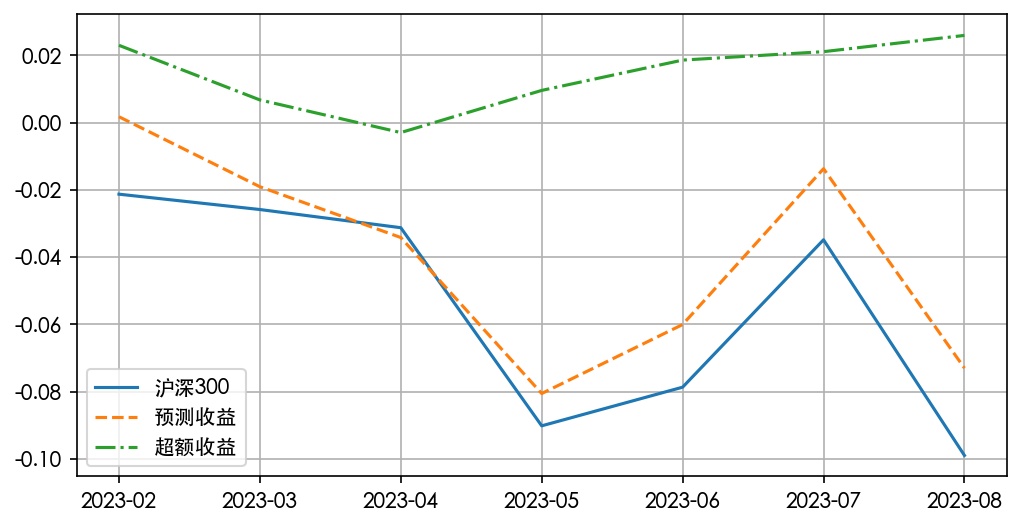

In [22]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(sw['沪深300'][-7:].cumsum(),label='沪深300')
plt.plot(pd.Series(li[1:]).cumsum(),label='预测收益',linestyle='--')
plt.plot((li[1:]-sw['沪深300'][-7:]).cumsum(),label='超额收益',linestyle='-.')
plt.grid()
plt.legend()
plt.show()

# ESG

In [23]:
industry = pd.read_csv('stock_industry.csv',index_col=0)
industry.head()

,801030,801080,801110,801120,801150,801170,801210,801750,801770,801780,801980
0,000420.XSHE,000020.XSHE,000016.XSHE,000529.XSHE,000028.XSHE,000088.XSHE,000428.XSHE,000004.XSHE,000063.XSHE,000001.XSHE,000523.XSHE
1,000422.XSHE,000021.XSHE,000333.XSHE,000568.XSHE,000078.XSHE,000089.XSHE,000430.XSHE,000034.XSHE,000070.XSHE,001227.XSHE,000615.XSHE
2,000510.XSHE,000045.XSHE,000404.XSHE,000596.XSHE,000153.XSHE,000099.XSHE,000524.XSHE,000066.XSHE,000586.XSHE,002142.XSHE,001206.XSHE
3,000525.XSHE,000050.XSHE,000521.XSHE,000716.XSHE,000403.XSHE,000429.XSHE,000526.XSHE,000158.XSHE,000836.XSHE,002807.XSHE,001328.XSHE
4,000545.XSHE,000062.XSHE,000541.XSHE,000729.XSHE,000411.XSHE,000520.XSHE,000610.XSHE,000409.XSHE,000839.XSHE,002839.XSHE,002094.XSHE


In [24]:
x = [row[j] for j in range(6) for row in ind]
ind_name = list(np.unique(x))
ind_code = ['801170','801150','801030','801110','801080','801210',"801980","801750",'801770','801780','801120']
ind_name_code = dict(zip(ind_name,ind_code))

In [25]:
bank = industry.loc[:,'801780'].dropna()
esg_index = pd.Series(esg.index)
s = esg_index[esg_index.isin(bank)]

In [26]:
bank_esg = esg.loc[s,'2018-09':].mean()

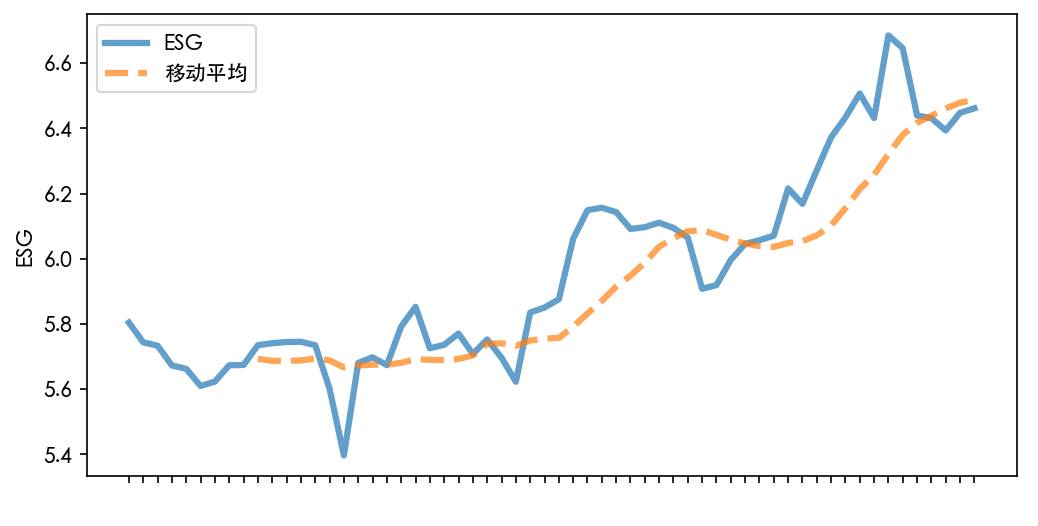

In [27]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(bank_esg,lw=3,alpha=0.7,label='ESG')
plt.plot(bank_esg.rolling(10).mean(),lw=3,alpha=0.7,linestyle='--',label='移动平均')
plt.legend()
plt.ylabel('ESG')
plt.xticks(alpha=0)
plt.show()

In [28]:
bank_esg = esg.loc[s,'2018-09':].mean()
bank_esg = bank_esg.rolling(20).mean()

In [29]:
bank_esg.loc['2022-02-28']

5.932478302440371

In [30]:
m = esg.columns[-8:-1]

In [31]:
#esg指标
df_ind_esg = pd.DataFrame(data=np.nan,index=ind_name_code.keys(),columns=m)
cnt = 0
esg_index = pd.Series(esg.index)
for i in ind[1:]:
    for j in i:
        c = ind_name_code.get(j)
        stock_name = industry.loc[:,c].dropna()
        try:
            s = esg_index[esg_index.isin(stock_name)]
            bank_esg = esg.loc[s,'2018-09':].mean()
            bank_esg = bank_esg.rolling(10).mean()
            df_ind_esg.loc[j,m[cnt]] = bank_esg.loc[m[cnt]]
        except:
            df_ind_esg.loc[j,m[cnt]] = np.nan
    cnt += 1
df_ind_esg.columns = sw.index[-7:]

In [32]:
df_ind_esg

时间,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
交通运输(申万),5.939597,5.932815,NaN,5.913385,NaN,5.942338,5.961279
医药生物(申万),6.278989,6.308589,NaN,NaN,NaN,NaN,NaN
基础化工(申万),NaN,NaN,6.141152,6.139682,6.125873,6.117018,6.106220
家用电器(申万),6.046288,6.032532,6.012031,6.000709,5.998949,6.007742,6.011643
电子(申万),NaN,NaN,NaN,NaN,NaN,NaN,6.157774
社会服务(申万),5.938533,5.929671,5.911492,NaN,5.870694,NaN,NaN
美容护理(申万),6.413208,6.461565,6.502696,6.543036,6.543821,6.551607,NaN
计算机(申万),NaN,NaN,NaN,NaN,6.350600,NaN,NaN
通信(申万),NaN,NaN,6.047393,6.052202,NaN,NaN,6.059880
银行(申万),6.257647,6.321600,6.380489,6.417357,NaN,6.461429,6.479071


# MV模型

In [33]:
class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0, **kwargs):
        super().__init__(n_var=len(sw_2.columns), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe
        

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [34]:
#拿8月份举例子
k = '2023-08'
sr_2 = df_ind_esg[k].dropna()
sw_2 = sw.loc['2018-01':'2023-07',sr_2.index]
#mu = sw_2.mean()

li_stable = []
for i in sr_2.index:
    params = levy_stable.fit(sw_2.loc[:,i].values)
    li_stable.append(params[2])

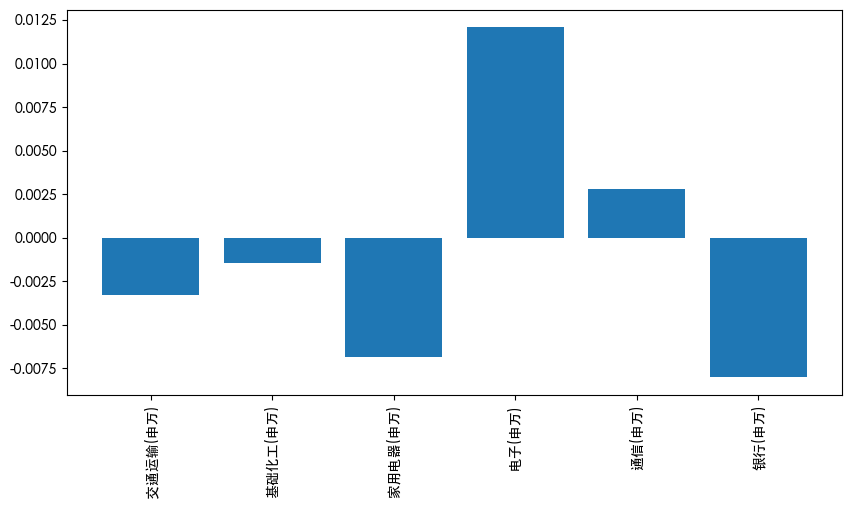

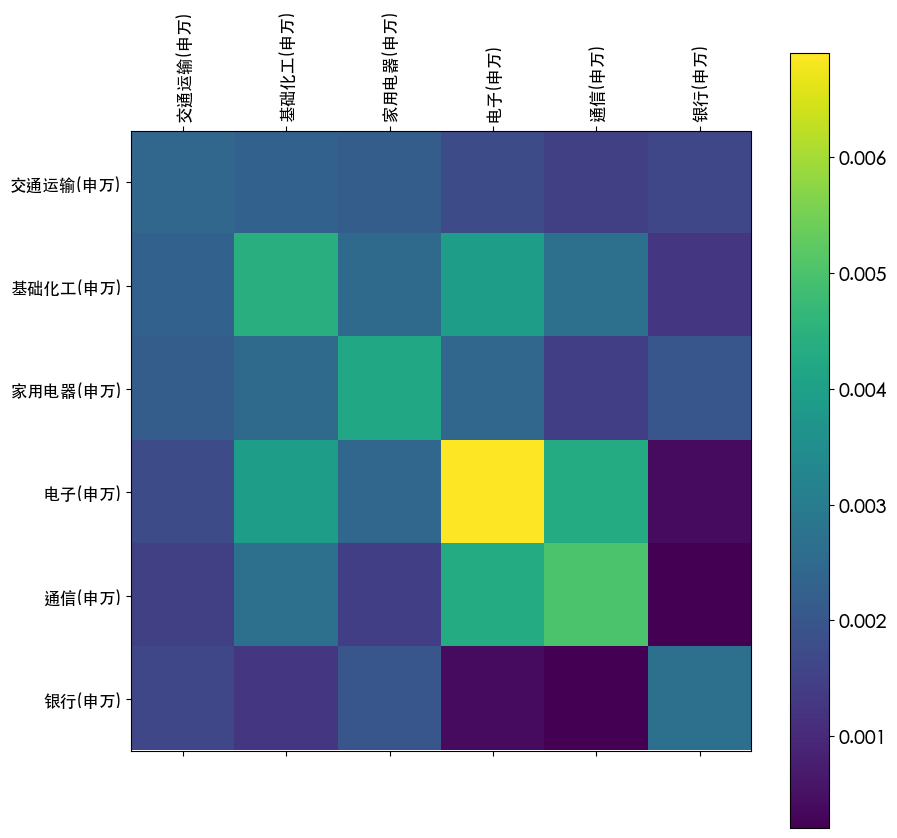

In [35]:
mu = np.array(li_stable)
cov = sw_2.cov()
cov = cov.to_numpy()

labels = sw_2.columns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()


f = plt.figure(figsize=(10, 10))
plt.matshow(cov,fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
#print("DONE")

In [36]:
problem = PortfolioProblem(mu, cov)

algorithm = SMSEMOA(repair=PortfolioRepair())

res = minimize(problem,
               algorithm,
               seed=1,
               verbose=False)

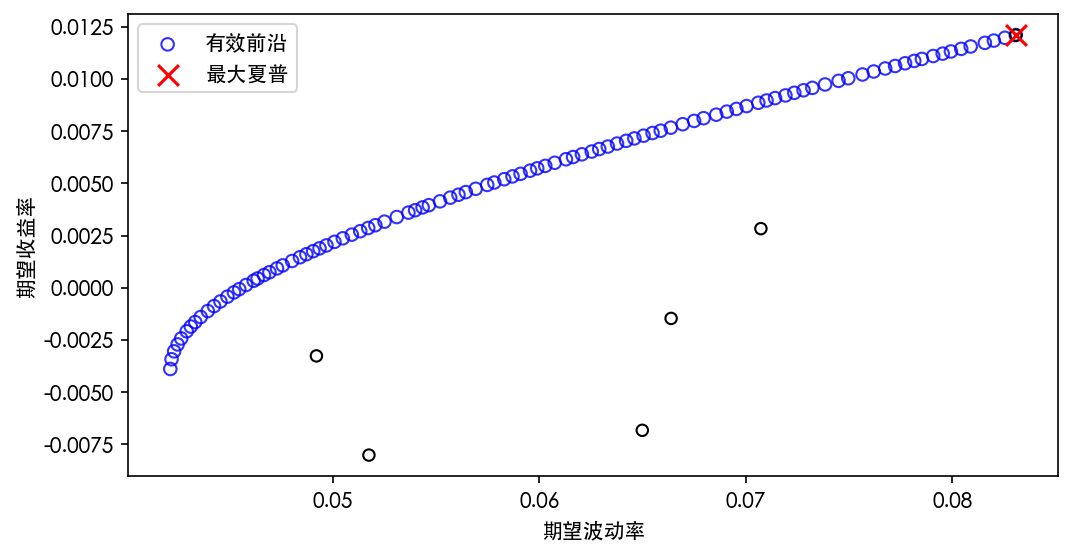

In [37]:
plt.figure(figsize=(8,4),dpi=150)
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.8, label="有效前沿")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30)
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="最大夏普")
plt.legend()
plt.xlabel("期望波动率")
plt.ylabel("期望收益率")
plt.show()

In [38]:
import operator

allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

Allocation With Best Sharpe
电子(申万) 1.0
交通运输(申万) 0.0
基础化工(申万) 0.0
家用电器(申万) 0.0
通信(申万) 0.0
银行(申万) 0.0


In [144]:
m_col = df_ind_esg.columns
k_1 = sw.index[-8:-1]
mv_return = []
#s_return = []
cnt = 0
for k in m_col:
    sr_2 = df_ind_esg[k].dropna()
    sw_2 = sw.loc['2019-01':k_1[cnt],sr_2.index]
    cnt += 1
    mu = sw_2.mean()
    
#     li_stable = []
#     for i in sr_2.index:
#         params = levy_stable.fit(sw_2.loc[:,i].values)
#         li_stable.append(params[2])
    cov = sw_2.cov()
    #mu, cov = np.array(li_stable), cov.to_numpy()
    mu, cov = mu.to_numpy(), cov.to_numpy() 
    problem = PortfolioProblem(mu, cov)
    algorithm = SMSEMOA(repair=PortfolioRepair())
    res = minimize(problem,
                   algorithm,
                   seed=1,
                   verbose=False)
    X, F, sharpe = res.opt.get("X", "F", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
    allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)


    for name, w in allocation:
        print(f"{name:<5} {w}")
    name = [n[0] for n in allocation]
    r = [n[1] for n in allocation]
    sw_returns_2 = sw.loc[k,name]
    
    mv_return.append(sum(sw_returns_2.values*np.array(r)))

美容护理(申万) 0.57142014043784
社会服务(申万) 0.3258929564806913
家用电器(申万) 0.06961389525194124
医药生物(申万) 0.033073007829527545
交通运输(申万) 0.0
银行(申万) 0.0
美容护理(申万) 0.596946770650494
社会服务(申万) 0.3571837078272724
家用电器(申万) 0.04586952152223369
交通运输(申万) 0.0
医药生物(申万) 0.0
银行(申万) 0.0
基础化工(申万) 0.5884293747807313
美容护理(申万) 0.23133609473017694
社会服务(申万) 0.1802345304890917
家用电器(申万) 0.0
通信(申万) 0.0
银行(申万) 0.0
基础化工(申万) 0.5768524845128685
美容护理(申万) 0.3673163341808313
家用电器(申万) 0.05583118130630022
交通运输(申万) 0.0
通信(申万) 0.0
银行(申万) 0.0
食品饮料(申万) 0.5594850695491619
基础化工(申万) 0.24181799303609527
计算机(申万) 0.17935512467637224
社会服务(申万) 0.019341812738370653
家用电器(申万) 0.0
美容护理(申万) 0.0
食品饮料(申万) 0.5683128346334332
基础化工(申万) 0.43168716536656676
交通运输(申万) 0.0
家用电器(申万) 0.0
美容护理(申万) 0.0
银行(申万) 0.0
基础化工(申万) 0.5309557081474733
电子(申万) 0.23674624900638883
家用电器(申万) 0.2322980428461379
交通运输(申万) 0.0
通信(申万) 0.0
银行(申万) 0.0


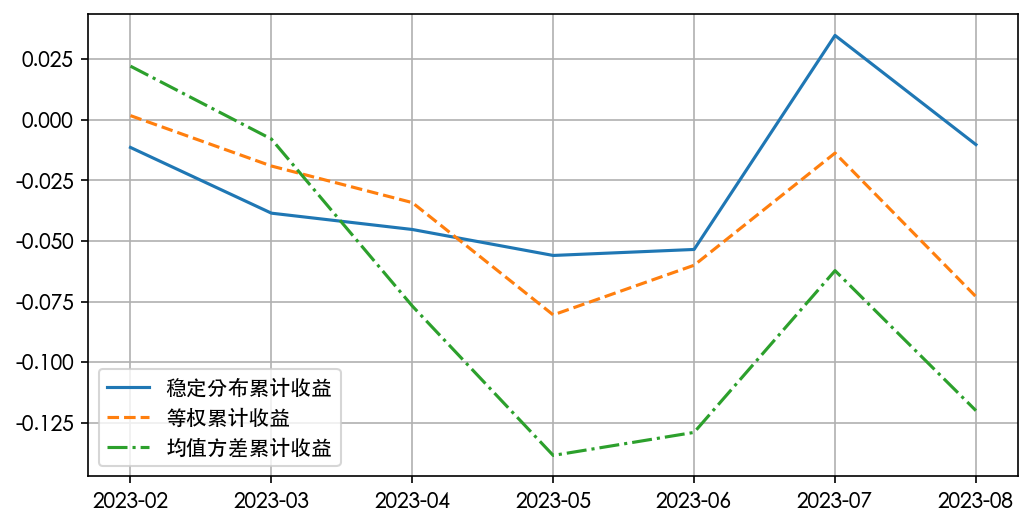

In [163]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(pd.Series(s_return,index=list(sw.index[-7:].values)).cumsum(),label='稳定分布累计收益')
plt.plot(pd.Series(li[1:]).cumsum(),label='等权累计收益',linestyle='--')
plt.plot(pd.Series(mv_return).cumsum(),label='均值方差累计收益',linestyle='-.')
#plt.xlabel()
plt.grid()
plt.legend()
plt.show()

In [41]:
class PortfolioProblem_esg_var(ElementwiseProblem):

    def __init__(self, mu, cov, esg, g, risk_free_rate=0, **kwargs):
        super().__init__(n_var=len(sw_2.columns), n_obj=2, n_eq_constr=1, xl=-0.3, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate
        self.esg = esg
        self.g = g

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = x @ self.cov
        exp_esg = x @ self.esg
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_esg]
        out["H"] = self.g - exp_return
        out["sharpe"] = sharpe
        

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [39]:
m_col = df_ind_esg.columns
k_1 = sw.index[-8:-1]
li_stable = []
std_stable = []
cnt = 0
for k in m_col:
    print("开始",k)
    sr_2 = df_ind_esg[k].dropna()
    sw_2 = sw.loc['2019-01':k_1[cnt],sr_2.index]
    cnt += 1
    li = []
    li_std = []
    for i in sr_2.index:
        params = levy_stable.fit(sw_2.loc[:,i].values)
        li.append(params[2])
        li_std.append(params[3])
    li_stable.append(li)
    std_stable.append(li_std)

开始 2023-02
开始 2023-03
开始 2023-04
开始 2023-05
开始 2023-06
开始 2023-07
开始 2023-08


In [40]:
def cvar(df):
    li = []
    for i in df.columns:
        x = df.loc[:,i]
        x_5 = np.percentile(df.loc[:,i],10)
        #cvar = x[x<=x_5].mean()
        li.append(x_5)
    return li

In [43]:
m_col = df_ind_esg.columns
k_1 = sw.index[-8:-1]
esg_return = []
cnt = 0
for k in m_col:
    print("开始",k)
    sr_2 = df_ind_esg[k].dropna()
    sw_2 = sw.loc[:k_1[cnt],sr_2.index]
    stable_return = li_stable[cnt]
    cnt += 1    
    cov = cvar(sw_2)
    cov = np.array(cov)#cov.to_numpy()
    mu, cov = np.array(stable_return), np.array(cov)
    m_s = []
    m_w = []
    m_n = []
    esg_2 = df_ind_esg[k].dropna().values
    for i in np.arange(min(stable_return),max(stable_return),0.001):
        problem = PortfolioProblem_esg_var(mu, cov, esg_2, i)
        algorithm = SMSEMOA(repair=PortfolioRepair())
        res = minimize(problem,
                       algorithm,
                       seed=1,
                       verbose=False)
        X, F, sharpe = res.opt.get("X", "F", "sharpe")
        F = F * [1, -1]
        max_sharpe = sharpe.argmax()
        allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
        allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)
        m_s.append(list(np.append(i,F[max_sharpe])))
        m_n.append([n[0] for n in allocation])
        m_w.append([n[1] for n in allocation])
    
    idx_max = np.array([row[0]/row[1] for row in m_s]).argmax()
    shouyi = sum(sw.loc[k,m_n[idx_max]].values*m_w[idx_max])
    esg_return.append(shouyi)
    print(esg_return)

开始 2023-02
[0.003243556986617302]
开始 2023-03


/var/folders/7q/z47ypzbd7g56p69vqz0q_2ph0000gn/T/ipykernel_40891/1398974514.py:26: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


[0.003243556986617302, -0.00840955725408486]
开始 2023-04


/var/folders/7q/z47ypzbd7g56p69vqz0q_2ph0000gn/T/ipykernel_40891/1398974514.py:26: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


[0.003243556986617302, -0.00840955725408486, 0.03381385519822812]
开始 2023-05
[0.003243556986617302, -0.00840955725408486, 0.03381385519822812, -0.07579678299094739]
开始 2023-06


/var/folders/7q/z47ypzbd7g56p69vqz0q_2ph0000gn/T/ipykernel_40891/1398974514.py:26: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


[0.003243556986617302, -0.00840955725408486, 0.03381385519822812, -0.07579678299094739, 0.09518330562120442]
开始 2023-07


/var/folders/7q/z47ypzbd7g56p69vqz0q_2ph0000gn/T/ipykernel_40891/1398974514.py:26: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


[0.003243556986617302, -0.00840955725408486, 0.03381385519822812, -0.07579678299094739, 0.09518330562120442, 0.008536585306385134]
开始 2023-08


/var/folders/7q/z47ypzbd7g56p69vqz0q_2ph0000gn/T/ipykernel_40891/1398974514.py:26: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


[0.003243556986617302, -0.00840955725408486, 0.03381385519822812, -0.07579678299094739, 0.09518330562120442, 0.008536585306385134, -0.0820040898975493]


In [20]:
sve = [-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393, 0.0027518395440587367, 0.08636586644163262, -0.044457550984572804]
print(sve)
print(np.std(sve))

[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393, 0.0027518395440587367, 0.08636586644163262, -0.044457550984572804]
0.03863795158093679


In [22]:
sce = [0.026456395931633844, -0.010818073902953704, -0.05495584752604439, -0.003638164416714256, 0.00452361544345546, 0.08414641504784243, -0.04233713364540788]
print(sce)
print(np.std(sce))


[0.026456395931633844, -0.010818073902953704, -0.05495584752604439, -0.003638164416714256, 0.00452361544345546, 0.08414641504784243, -0.04233713364540788]
0.04266520632072749


In [21]:
svare = [0.02636163526107056, -0.012635644984492942, -0.054840647948943944, -0.003642573905801798, 0.00451791754145681, 0.08414635917257819, -0.04238705732587682]
print(svare)
print(np.std(svare))


[0.02636163526107056, -0.012635644984492942, -0.054840647948943944, -0.003642573905801798, 0.00451791754145681, 0.08414635917257819, -0.04238705732587682]
0.04271619677382552


In [2]:
import numpy as np
np.std(svare)

0.04271619677382552

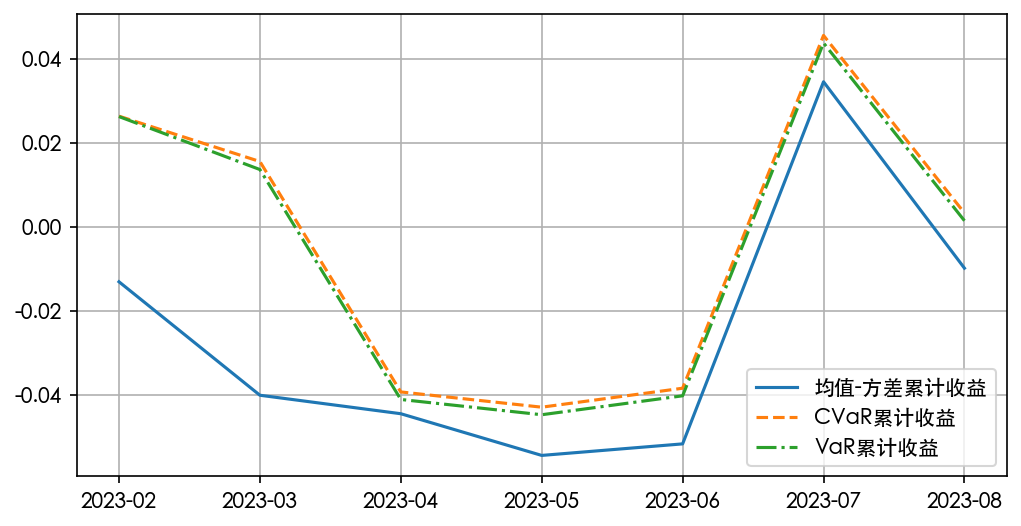

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(8,4),dpi=150)
plt.plot(pd.Series(sve,index=list([i[:-3] for i in sw.index[-7:].values])).cumsum(),label='均值-方差累计收益')
plt.plot(pd.Series(sce).cumsum(),label='CVaR累计收益',linestyle='--')
plt.plot(pd.Series(svare).cumsum(),label='VaR累计收益',linestyle='-.')
#plt.xlabel()
plt.grid()
plt.legend()
plt.show()

['2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08']

In [68]:
class PortfolioProblem_esg(ElementwiseProblem):

    def __init__(self, mu, cov, esg, g, risk_free_rate=0, **kwargs):
        super().__init__(n_var=len(sw_2.columns), n_obj=2, n_eq_constr=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate
        self.esg = esg
        self.g = g

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        exp_esg = x @ self.esg
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_esg]
        out["H"] = self.g - exp_return
        out["sharpe"] = sharpe
        

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [176]:
m_col = df_ind_esg.columns
k_1 = sw.index[-8:-1]
esg_return = []
cnt = 0
for k in m_col:
    print("开始",k)
    sr_2 = df_ind_esg[k].dropna()
    sw_2 = sw.loc['2019-01':k_1[cnt],sr_2.index]
    cnt += 1    
    li_stable = []
    for i in sr_2.index:
        params = levy_stable.fit(sw_2.loc[:,i].values)
        li_stable.append(params[2])
    cov = sw_2.cov()
    mu, cov = np.array(li_stable), cov.to_numpy()
    #mu, cov = mu.to_numpy(), cov.to_numpy() 
    m_s = []
    m_w = []
    m_n = []
    for i in np.arange(min(li_stable),max(li_stable),0.001):
        problem = PortfolioProblem_esg(mu, cov, esg_2, i)
        algorithm = SMSEMOA(repair=PortfolioRepair())
        res = minimize(problem,
                       algorithm,
                       seed=1,
                       verbose=False)
        X, F, sharpe = res.opt.get("X", "F", "sharpe")
        F = F * [1, -1]
        max_sharpe = sharpe.argmax()
        allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
        allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)
        m_s.append(list(np.append(i,F[max_sharpe])))
        m_n.append([n[0] for n in allocation])
        m_w.append([n[1] for n in allocation])
    
    idx_max = np.array([row[0]/row[1] for row in m_s]).argmax()
    shouyi = sum(sw.loc[k,m_n[idx_max]].values*m_w[idx_max])
    esg_return.append(shouyi)
    print(esg_return)

开始 2023-02
[-0.0130429065023567]
开始 2023-03
[-0.0130429065023567, -0.02706286166822322]
开始 2023-04
[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985]
开始 2023-05
[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393]
开始 2023-06
[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393, 0.0027518395440587367]
开始 2023-07
[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393, 0.0027518395440587367, 0.08636586644163262]
开始 2023-08
[-0.0130429065023567, -0.02706286166822322, -0.0044082905569096985, -0.009944693285188393, 0.0027518395440587367, 0.08636586644163262, -0.044457550984572804]


In [70]:
sr_2 = df_ind_esg['2023-08'].dropna()
sw_2 = sw.loc['2019-01':'2023-07',sr_2.index]

In [142]:
cov = sw_2.cov()
esg_2 = df_ind_esg['2023-08'].dropna().values
mu,cov = np.array(li_stable),cov.to_numpy()

In [143]:
m_s = []
m_w = []
m_n = []
for i in np.arange(min(li_stable),max(li_stable),0.001):
    problem = PortfolioProblem_esg(mu, cov, esg_2, i)
    algorithm = SMSEMOA(repair=PortfolioRepair())
    res = minimize(problem,
                   algorithm,
                   seed=1,
                   verbose=False)
    X, F, sharpe = res.opt.get("X", "F", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
    allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)
    m_s.append(list(np.append(i,F[max_sharpe])))
    m_n.append([n[0] for n in allocation])
    m_w.append([n[1] for n in allocation])

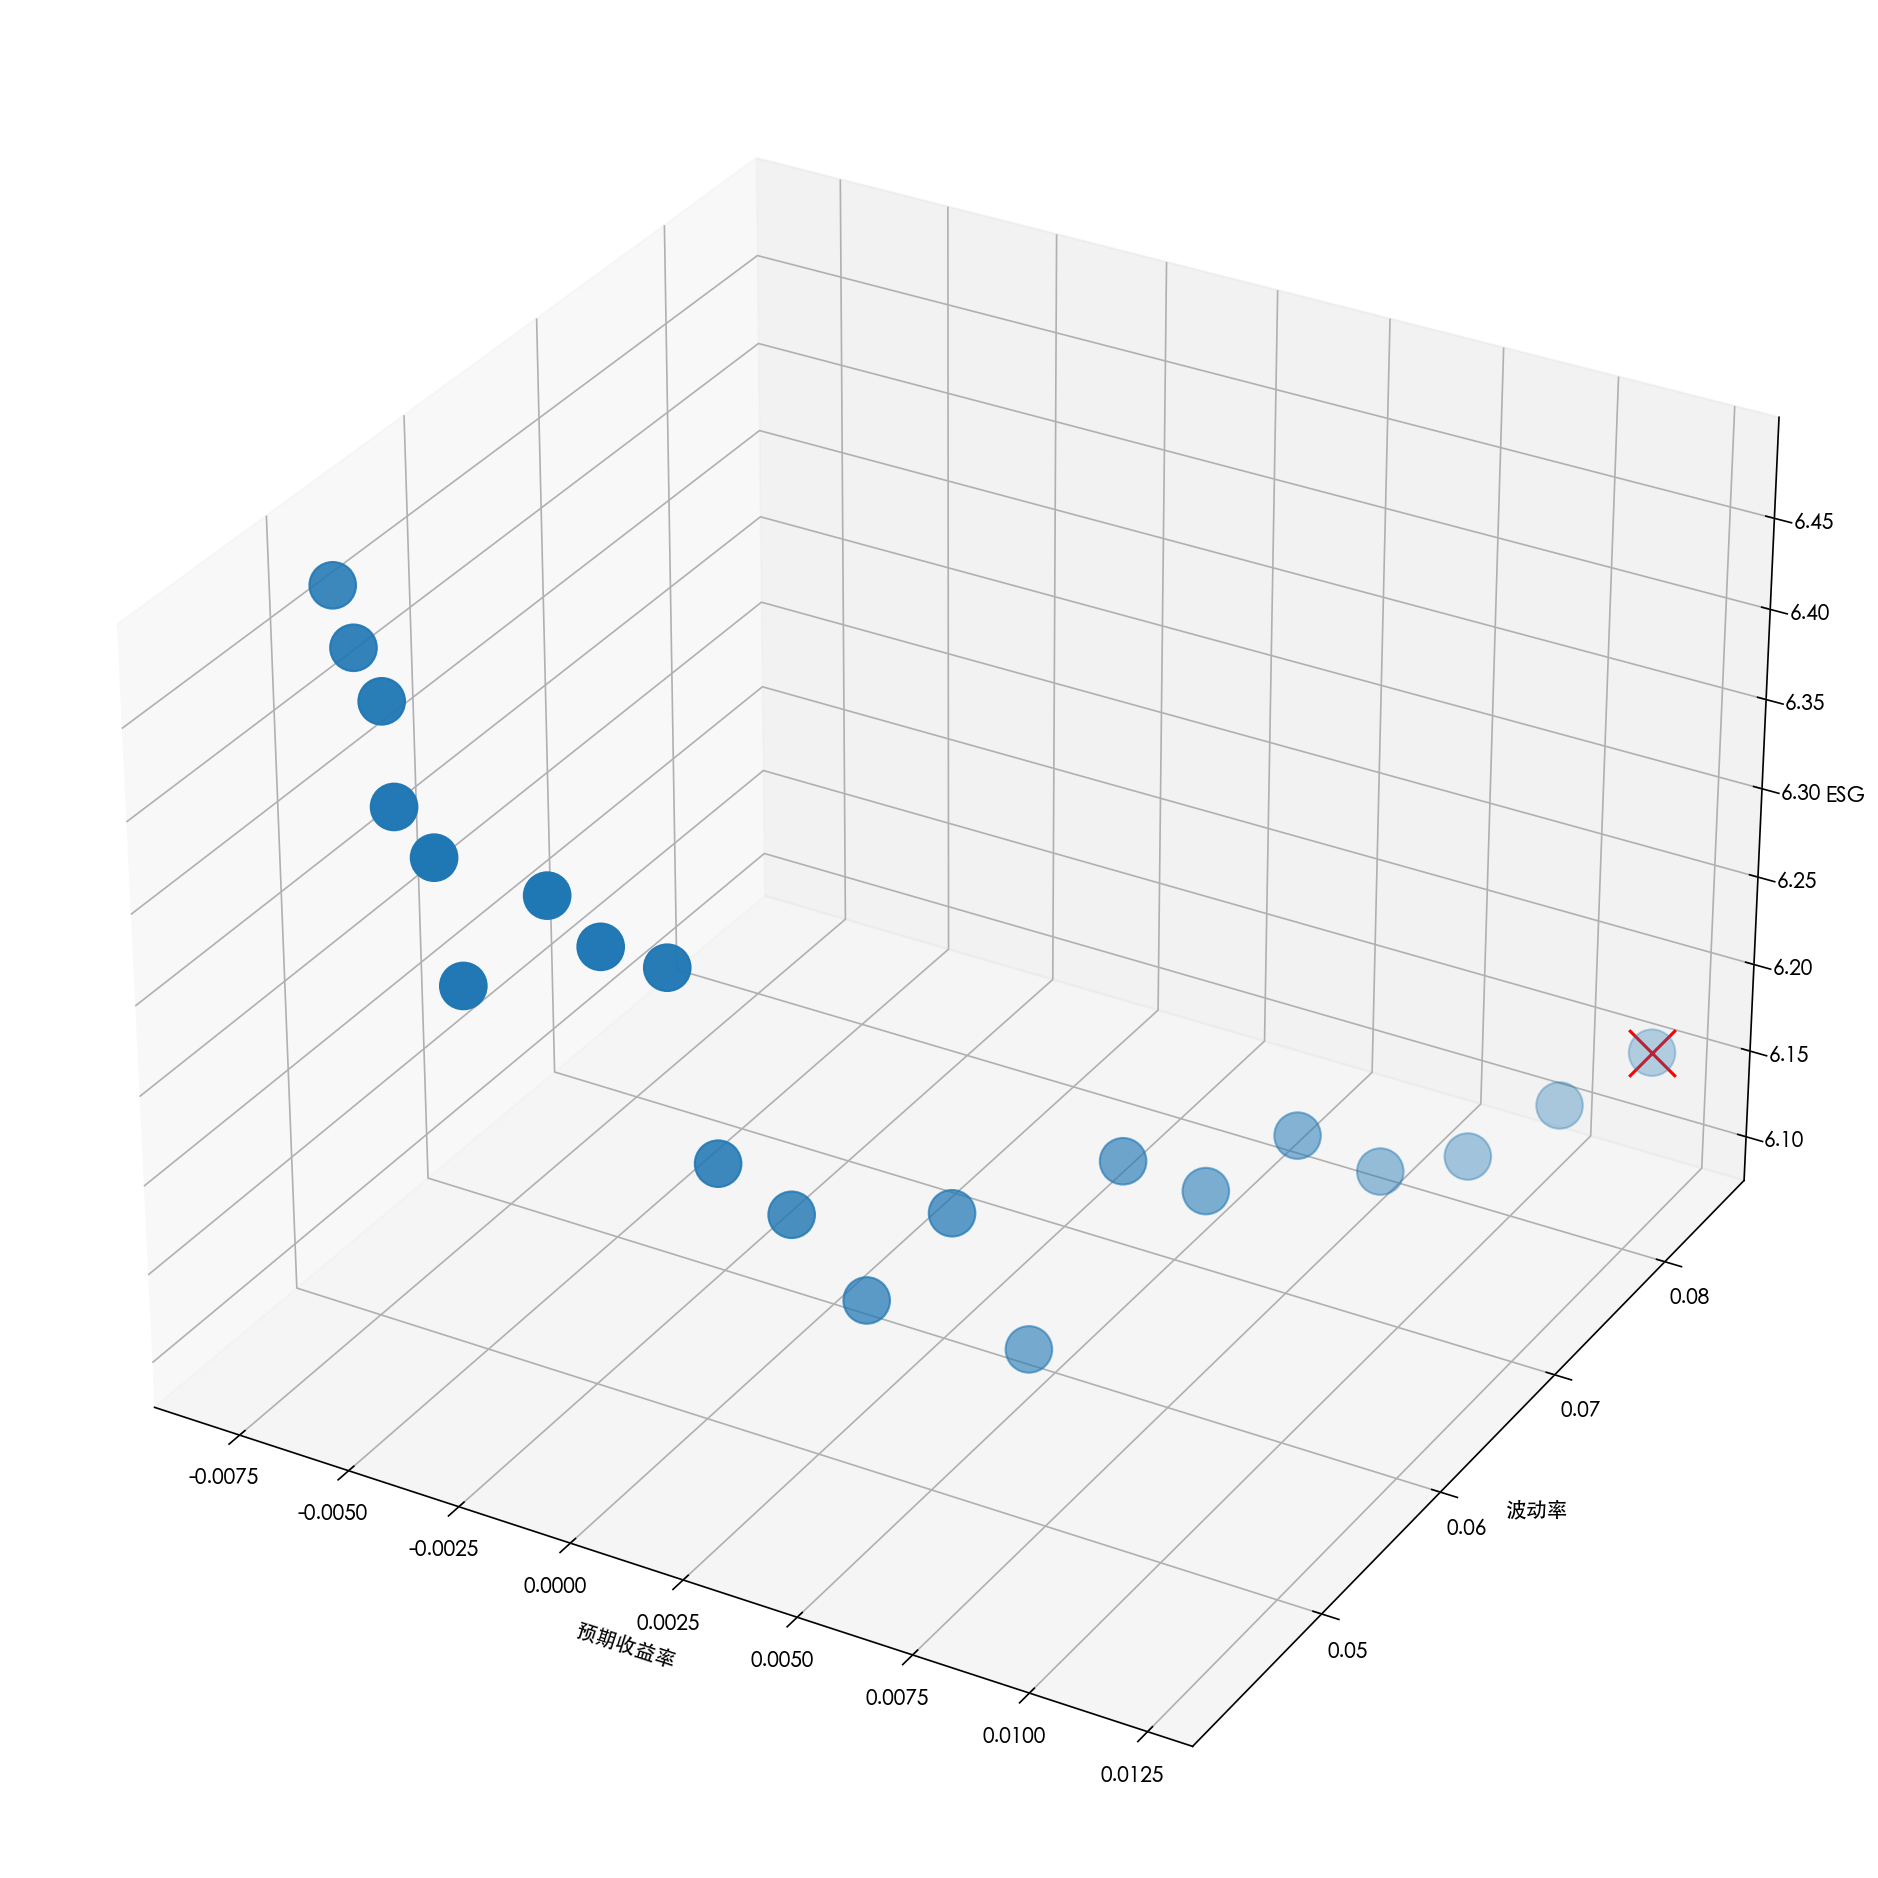

In [161]:
x, y, z = zip(*m_s)

# 创建3D图形
fig = plt.figure(figsize=(16,16),dpi=150)
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(x, y, z,s=500)
ax.scatter(x[20], y[20], z[20], marker="x", s=500, color="red", label="最大夏普")
# 设置坐标轴标签
ax.set_xlabel('预期收益率')
ax.set_ylabel('波动率')
ax.set_zlabel('ESG')

# 显示图形
plt.show()

In [188]:
m_w[11]

[0.7607243787311245, 0.13252999250229575, 0.10674562876657973, 0.0, 0.0, 0.0]

In [182]:
np.std(esg_return)

0.03863795158093679

In [192]:
sum(esg_return)

-0.009798597011559461

In [183]:
np.std(s_return)

0.039400442841695034

In [194]:
np.std(s_return)

0.039400442841695034

In [195]:
sum(li[1:])

-0.07297423726862033

In [10]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(pd.Series(s_return,index=list(sw.index[-7:].values)).cumsum(),label='稳定分布累计收益')
plt.plot(pd.Series(li[1:]).cumsum(),label='等权累计收益',linestyle='--')
plt.plot(pd.Series(esg_return).cumsum(),label='ESG累计收益',linestyle='-.')
#plt.xlabel()
plt.grid()
plt.legend()
plt.show()

NameError: name 's_return' is not defined

<Figure size 1200x600 with 0 Axes>

In [71]:
df_ind_esg

时间,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
交通运输(申万),5.939597,5.932815,NaN,5.913385,NaN,5.942338,5.961279
医药生物(申万),6.278989,6.308589,NaN,NaN,NaN,NaN,NaN
基础化工(申万),NaN,NaN,6.141152,6.139682,6.125873,6.117018,6.106220
家用电器(申万),6.046288,6.032532,6.012031,6.000709,5.998949,6.007742,6.011643
电子(申万),NaN,NaN,NaN,NaN,NaN,NaN,6.157774
社会服务(申万),5.938533,5.929671,5.911492,NaN,5.870694,NaN,NaN
美容护理(申万),6.413208,6.461565,6.502696,6.543036,6.543821,6.551607,NaN
计算机(申万),NaN,NaN,NaN,NaN,6.350600,NaN,NaN
通信(申万),NaN,NaN,6.047393,6.052202,NaN,NaN,6.059880
银行(申万),6.257647,6.321600,6.380489,6.417357,NaN,6.461429,6.479071


In [678]:
cov = sw_2.cov()
esg_2 = df_ind_esg[k].dropna().values
mu, cov = np.array(li_stable), cov.to_numpy()
m_s = []
m_w = []
m_n = []
for i in np.arange(min(li_stable),max(li_stable),0.001):
    problem = PortfolioProblem_esg(mu, cov, esg_2, i)
    algorithm = SMSEMOA(repair=PortfolioRepair())
    res = minimize(problem,
                   algorithm,
                   seed=1,
                   verbose=False)
    X, F, sharpe = res.opt.get("X", "F", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    allocation = {name: w for name, w in zip(sw_2.columns, X[max_sharpe])}
    allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)
    m_s.append(list(np.append(i,F[max_sharpe])))
    m_n.append([n[0] for n in allocation])
    m_w.append([n[1] for n in allocation])

In [683]:
m_w

[[0.9811441517595265,
  0.014397093766067912,
  0.0027207539391014054,
  0.001738000535304159,
  0.0,
  0.0],
 [0.7560319375174515, 0.2418519063966991, 0.002116156085849521, 0.0, 0.0, 0.0],
 [0.5421400053912937, 0.4390716021236377, 0.018788392485068563, 0.0, 0.0, 0.0],
 [0.6778832791721882,
  0.315410010820813,
  0.004653040373529982,
  0.002053669633468845,
  0.0,
  0.0],
 [0.8834113532604942,
  0.09690067085287625,
  0.014990164388912913,
  0.004697811497716719,
  0.0,
  0.0],
 [0.7613042991774485, 0.20987376552907278, 0.02882193529347876, 0.0, 0.0, 0.0],
 [0.6210929085762519, 0.37890709142374823, 0.0, 0.0, 0.0, 0.0],
 [0.9884315246296316,
  0.008281309090999339,
  0.0020350550249025497,
  0.0012521112544665361,
  0.0,
  0.0],
 [0.6745616594223873, 0.1756335789682527, 0.14980476160936004, 0.0, 0.0, 0.0],
 [0.45913229719018944,
  0.396758014046341,
  0.128200616338904,
  0.015909072424565508,
  0.0,
  0.0],
 [0.6010277915225241, 0.39162383365493, 0.007348374822545986, 0.0, 0.0, 0.0],


In [682]:
df_ind_esg['2023-08-31']

交通运输(申万)    6.002033
医药生物(申万)         NaN
基础化工(申万)    5.945121
家用电器(申万)    5.903125
电子(申万)      6.007924
社会服务(申万)         NaN
美容护理(申万)         NaN
计算机(申万)          NaN
通信(申万)      5.986129
银行(申万)      6.461905
食品饮料(申万)         NaN
Name: 2023-08-31, dtype: float64

In [680]:
for i in range(len(m_w)):
    q1 = sw.loc['2023-08',list(m_n[i])]
    q2 = m_w[i]
    print(sum(q1.values*np.array(q2)))

-0.06683278094504795
-0.07046076234405
-0.07357407917023033
-0.07728652303074675
-0.08042822416540871
-0.07564605730373795
-0.06371171003804782
-0.05234177690234614
-0.05172221514696785
-0.050668717447241565
-0.04508928228288716
-0.0423315388849092


In [672]:
m_n

[['银行(申万)', '通信(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['银行(申万)', '通信(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['银行(申万)', '通信(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['银行(申万)', '通信(申万)', '电子(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)'],
 ['银行(申万)', '通信(申万)', '电子(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)'],
 ['银行(申万)', '通信(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['通信(申万)', '银行(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['通信(申万)', '银行(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['通信(申万)', '银行(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['通信(申万)', '银行(申万)', '交通运输(申万)', '基础化工(申万)', '家用电器(申万)', '电子(申万)'],
 ['通信(申万)', '家用电器(申万)', '交通运输(申万)', '银行(申万)', '基础化工(申万)', '电子(申万)'],
 ['通信(申万)', '家用电器(申万)', '银行(申万)', '交通运输(申万)', '基础化工(申万)', '电子(申万)']]

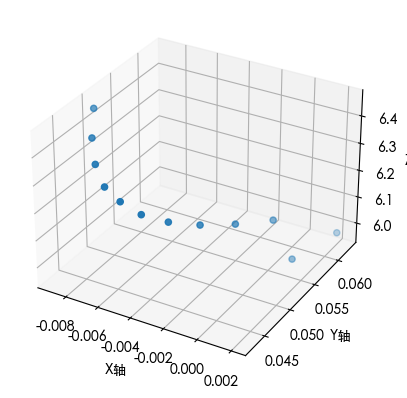

[-0.004510226186267843,
 -0.0016015544429751854,
 -0.0018883190976977564,
 2.0221045204482456e-05,
 0.002829570148204494,
 -0.008973287407274495]

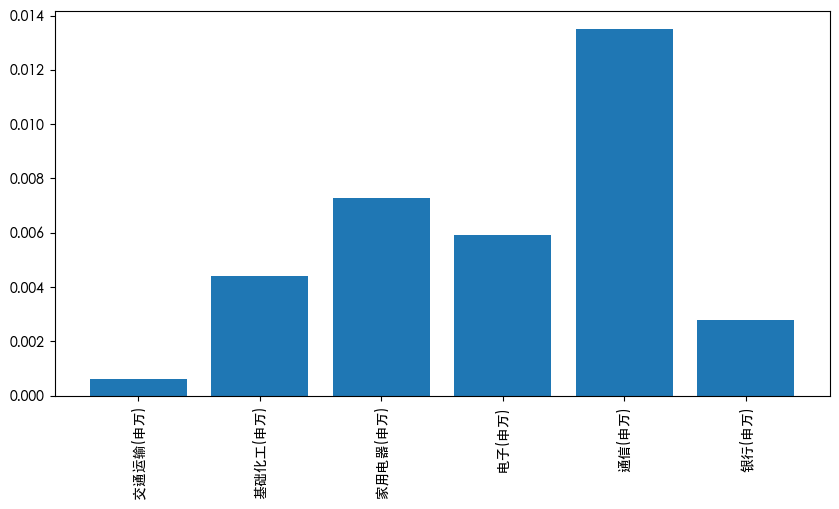

DONE


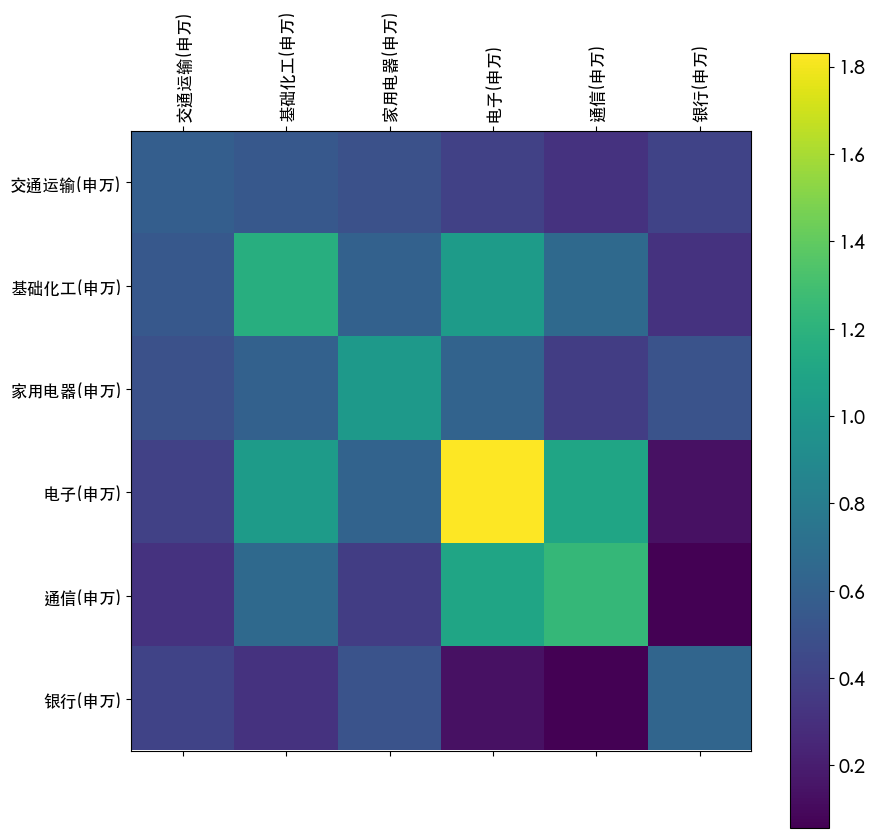

In [153]:
mu = np.array(li_stable)
cov = sw_2.cov() * 252

cov = cov.to_numpy()

labels = sr_2.index

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()


f = plt.figure(figsize=(10, 10))
plt.matshow(cov, fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
print("DONE")

In [701]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0, **kwargs):
        super().__init__(n_var=len(df.columns), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe
from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)
    
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize

problem = PortfolioProblem(mu, cov)

algorithm = SMSEMOA(repair=PortfolioRepair())


In [552]:
name = [n[0] for n in allocation]
r = [n[1] for n in allocation]
sw_returns_2 = sw_returns.loc['2023-06-30',name]

In [553]:
sum(sw_returns_2.values*np.array(r))

0.004287092323873873

In [570]:
sw_returns_2

食品饮料(申万)    0.005452
社会服务(申万)   -0.004101
基础化工(申万)    0.025202
家用电器(申万)    0.106602
美容护理(申万)   -0.012561
计算机(申万)     0.002482
Name: 2023-06-30, dtype: float64

In [539]:
df_ind_esg

时间,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31
交通运输(申万),5.943852,5.948689,NaN,6.044959,NaN,6.042114,6.002033
医药生物(申万),6.397650,6.367581,NaN,NaN,NaN,NaN,NaN
基础化工(申万),NaN,NaN,6.128923,6.113945,5.992038,6.004182,5.945121
家用电器(申万),6.038608,6.027722,6.109114,6.079114,5.954125,5.958250,5.903125
电子(申万),NaN,NaN,NaN,NaN,NaN,NaN,6.007924
社会服务(申万),5.934306,5.912361,5.920000,NaN,5.583288,NaN,NaN
美容护理(申万),6.601071,6.582143,6.624643,6.578571,6.465000,6.495000,NaN
计算机(申万),NaN,NaN,NaN,NaN,6.204984,NaN,NaN
通信(申万),NaN,NaN,6.112393,6.141282,NaN,NaN,5.986129
银行(申万),6.685476,6.646190,6.439762,6.431667,NaN,6.448095,6.461905


# 稳定分布

In [62]:
sw.head()

,农林牧渔(申万),基础化工(申万),钢铁(申万),有色金属(申万),电子(申万),家用电器(申万),食品饮料(申万),纺织服饰(申万),轻工制造(申万),医药生物(申万),...,通信(申万),银行(申万),非银金融(申万),汽车(申万),机械设备(申万),煤炭(申万),石油石化(申万),环保(申万),美容护理(申万),沪深300
时间,,,,,,,,,,,,,,,,,,,,,
2005-01,-0.091520,-0.096565,-0.011726,-0.074765,-0.088332,-0.052202,-0.015057,-0.093564,-0.086026,-0.068574,...,0.001542,-0.016176,-0.154260,-0.039126,-0.075934,-0.095105,-0.143868,-0.081374,-0.122998,-0.046171
2005-02,0.101912,0.112083,0.082712,0.133786,0.109261,0.088622,0.080493,0.104651,0.065085,0.079358,...,0.071321,0.061897,0.148930,0.099919,0.106965,0.119352,0.124970,0.102109,0.078732,0.085381
2005-03,-0.119220,-0.093904,-0.093307,-0.132024,-0.175152,-0.144923,-0.036192,-0.152335,-0.131781,-0.092983,...,-0.156211,-0.091740,-0.215546,-0.193846,-0.126996,-0.113783,-0.108368,-0.153592,-0.130669,-0.098745
2005-04,-0.078417,-0.017071,-0.078404,-0.035165,-0.129978,0.017920,0.027224,-0.052308,-0.044924,-0.001767,...,-0.078174,0.086401,0.147666,-0.068767,-0.041256,0.003314,-0.020922,-0.081246,-0.052728,-0.010464
2005-05,-0.046904,-0.121006,-0.079510,-0.103224,-0.027125,-0.016320,-0.080874,-0.094995,-0.038947,-0.064622,...,-0.043883,-0.060022,-0.045712,0.021037,-0.079109,-0.133178,-0.106345,-0.054922,0.009624,-0.085549


In [68]:
x = sw['食品饮料(申万)']

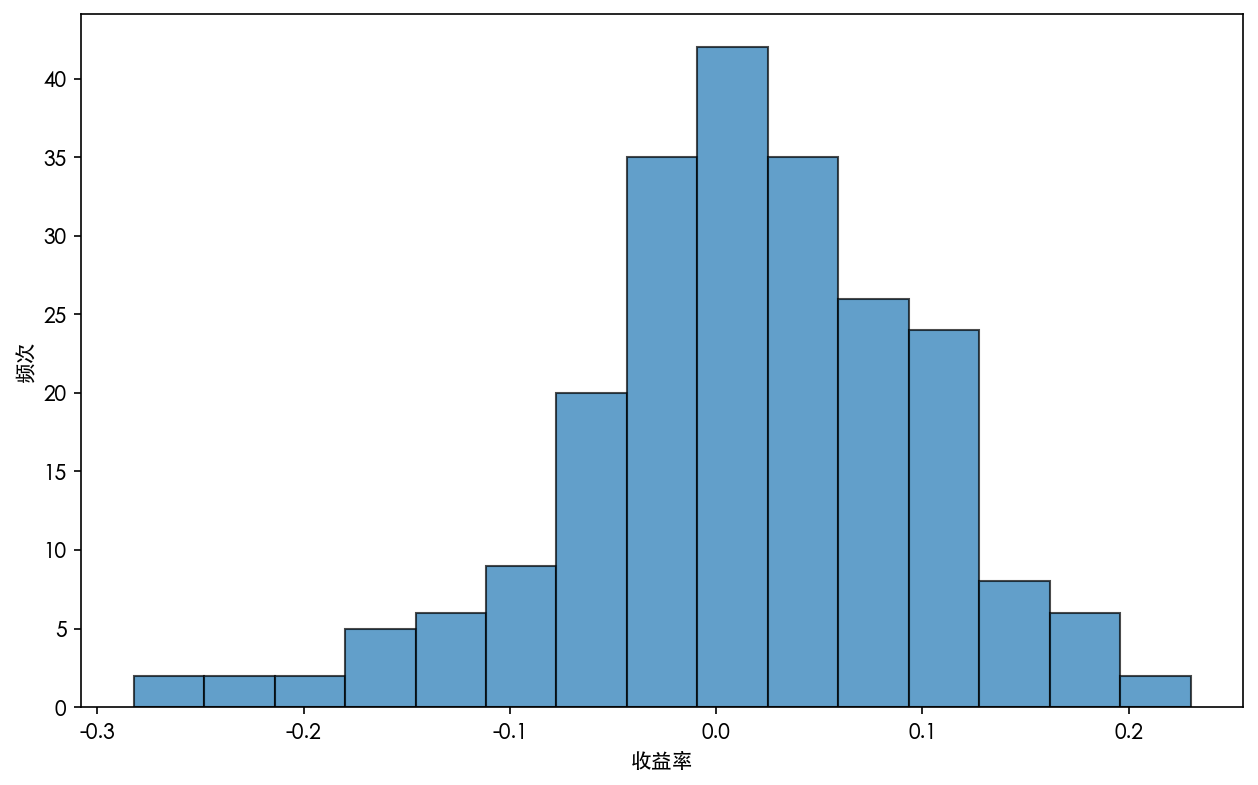

In [74]:
plt.figure(figsize=(10, 6),dpi=150)
plt.hist(x, bins=15, edgecolor='k', alpha=0.7)
plt.xlabel('收益率')
plt.ylabel('频次')
plt.show()